# Load libraries and setup rejection sampling

In [1]:
import numpy as np

np.random.seed(123456)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
import ipywidgets as wd

In [3]:
import scipy.stats as sstats 
from scipy.stats import norm, beta 

In [4]:
from scipy import optimize ### Use this for curve fitting

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler_1 = StandardScaler()

scaler_2 = StandardScaler()

scaler_3 = StandardScaler()

In [5]:
from scipy.stats import gaussian_kde as GKDE

In [6]:
def rejection_sampling(r):
    # Perform accept/reject sampling on a set of proposal samples using
    # the weights r associated with the set of samples and return
    # the indices idx of the proposal sample set that are accepted.
    N = r.size # size of proposal sample set
    check = np.random.uniform(low=0,high=1,size=N) # create random uniform weights to check r against
    M = np.max(r)
    new_r = r/M # normalize weights 
    idx = np.where(new_r>=check)[0] # rejection criterion
    return idx

# Time Series: Problems and Approaches

## Data and distributions on QoI

* A set of time series data typically represents a set of data for different quantities of interest (QoI) since each data point is defined by a different functional. 
<br>

    * A single datum is not enough to define/approximate a distribution for a QoI. But, if data are close enough in time there is a lot of correlation, so can we exploit that to construct distributions on a subset of QoI? 
   <br> <br>
    
    * We may take the perspective of a stochastic process and think of the data as coming from a statistical time series from a Markov process. From this perspective, we could try to turn the entire time series of data into a distribution on a single QoI. So, each datum represents the change in the Markov process and actually does come from a single distribution. 
<br>   

    
* ***The approaches discussed above both trade many values of data taken at many times for a statement of a distribution at a different time (or perhaps even for a QoI that is time invariant).***

## Fitting a time series model

* Alternatively, we may consider describing explicitly a stochastic time series model for the given data. 
From this perspective, we would try to find the best parameters for the time series model. 
This perspective is related to OED and determining frequency of data collection. 
<br><br>

* A time series model is likely only valid over certain time windows, and we need to define the window of time for which a model is valid, and this will subsequently define a different QoI. For example, over what time do you have a linear model? The collection of time windows defines different regimes for which different linear models are valid. This is related to data assimilation and EKF.

## Determining time windows for an ODE model

* How to determine time windows/regions over which time series models are valid? Investigate. This is a modeling question.

## Things to investigate and some references

Investigate the following:

* ROM for time dependent systems and the use of spectral decompositions. 

* Autoregressive models for time series data (https://en.wikipedia.org/wiki/Autoregressive_model)

* Connections to particle filtering and other types of data assimilation? https://en.wikipedia.org/wiki/Particle_filter

Some possibly useful references:

* http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

* https://campus.datacamp.com/courses/introduction-to-time-series-analysis-in-python/correlation-and-autocorrelation?ex=1
    * https://campus.datacamp.com/courses/introduction-to-time-series-analysis-in-python/autoregressive-ar-models?ex=7


# Some initial examples -- Proof of concept

## An ODE model

Model is for harmonic motion
$$y''(t) + 2cy'(t) + \omega_0^2 x = f(t)$$
with damping constant
$$c \in [0.1,1]$$
and natural frequency
$$\omega_0\in[0.5,2]$$
and forcing term initially taken to be zero.

Note that with the ranges of $c$ and $\omega_0$ above, it is possible for the system to either be under-, over-, or critically damped (and since $c\geq 0.1$ it is never undamped, which is almost always physical nonsense). 

The roots to the characteristic equation are given by
$$ r_1 = -c\pm \sqrt{c^2-\omega_0^2}$$.

When the system is under-damped, the solution is given by
$$ y(t) = e^{-ct}[C_1\cos(\omega t) + C_2\sin(\omega t)], \ \omega=\sqrt{\omega_0^2-c^2}. $$


When the system is over-damped, the solution is given by 
$$ y(t) = C_1 e^{r_1t}+C_2 e^{r_2t}. $$

And, finally, when the system is critically damped, the solution is given by
$$ y(t) = C_1e^{-ct} + C_2 te^{-ct}. $$

However, we never expect the system to be critically damped in practice since this is "too fine-tuned" of a scenario. 

The constants $C_1$ and $C_2$ are determined by the initial conditions, which we assume to be given by
$$ y(0)=a, y'(0) = b $$
where 
$$ a\in[1,2] $$ 
and 
$$ b\in[-1,0] $$. 

In the under-damped case, 
$$ C_1 = a, \ \text{and } \ C_2 = \frac{b+ca}{\omega}. $$

In the over-damped case, 
$$ C_1 = \frac{b-ar_2}{r_1-r_2}, \ \text{and } \ C_2 = \frac{b-r_1a}{r_2-r_1} $$

A ***true*** distribution of $c, \omega_0, a$, and $b$ are defined by (non-uniform) Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

### Time series data appended with differences and sums

We initially assume no errors in the time series data, i.e., the observations are $y(t)$ at some finite set of times $\{t_i\}_{i=1}^N$, with $0\leq t_1 < t_2 < \cdots < t_N$. 

We also take differences and summations of the time series (to extract derivative and integral type information) and append to the data to determine if new/dominant features (i.e., principal components) are found. 

In [7]:
def y(t, c, omega_0, a, b):
    z = np.zeros(len(c))
    ind_under = np.where(np.greater(omega_0, c))[0]
    ind_over = np.where(np.greater(c, omega_0))[0]
    # First solve for the under-damped case
    if ind_under.size > 0:
        omega = np.sqrt(omega_0[ind_under]**2 - c[ind_under]**2)
        C_1 = a[ind_under]
        C_2 = (b[ind_under]+c[ind_under]*a[ind_under])/omega
        
        z[ind_under] = np.exp(-c[ind_under]*t) * (C_1*np.cos(omega*t)
                                                  + C_2*np.sin(omega*t))
        
    if ind_over.size > 0:
        r_1 = -c[ind_over] - np.sqrt(c[ind_over]**2 - omega_0[ind_over]**2)
        r_2 = -c[ind_over] + np.sqrt(c[ind_over]**2 - omega_0[ind_over]**2)
        C_1 = (b[ind_over]-a[ind_over]*r_2)/(r_1-r_2)
        C_2 = (b[ind_over]-r_1*a[ind_over])/(r_2-r_1)
        
        z[ind_over] = C_1*np.exp(r_1*t) + C_2*np.exp(r_2*t)
        
    return z

#### Generate a test/prediction/prior set of parameters and observed data

In [8]:
# Uniformly sample the parameter samples to form a "prediction" or "test" set

num_samples = int(1E3)

lam = np.random.uniform(size=(num_samples,4))

lam[:,0] = 0.1 + 0.4*lam[:,0]  #c
lam[:,1] = 0.5 + 1.5*lam[:,1] #omega_0
lam[:,2] = 1 + 1*lam[:,2] #a
lam[:,3] = -1 + 1*lam[:,3]   #b

In [9]:
# Construct the predicted time series data

num_time_obs = int(50) #number of observations (uniformly space) between [time_start,time_end]
time_start = 0.5
time_end = 3.5
times = np.linspace(time_start, time_end, num_time_obs)

Q_samples_TS = np.zeros((num_samples,num_time_obs))

for i in range(num_time_obs):
    Q_samples_TS[:,i] = y(times[i],lam[:,0],lam[:,1],lam[:,2],lam[:,3])

#### Generate an observed set of data from a different distribution on parameters

The idea here is to show that we can reconstruct/recover a "true" distribution on parameters from observations. 
This establishes that we are indeed ***inverting*** a distribution on outputs.

However, in practice, we may only observe a ***single*** time series of data, polluted by noise, and impose a distribution on this time series data to invert.

Below, we simulate a peaked Beta distribution on a subset of the whole parameter space.

In [10]:
# Simulate an observed distribution of time series data

num_obs_samples = int(1E3)

true_a = 2
true_b = 2

lam_obs = np.random.beta(size=(num_obs_samples,4),a=true_a,b=true_b)

lam_obs[:,0] = 0.1 + 0.4*lam_obs[:,0]  #c
lam_obs[:,1] = 0.5 + 1.5*lam_obs[:,1]  #omega_0
lam_obs[:,2] = 1 + 1*lam_obs[:,2]   #a
lam_obs[:,3] = -1 + 1*lam_obs[:,3]   #b

In [11]:
Q_obs_samples_TS = np.zeros((num_obs_samples,num_time_obs))

with_noise = False
noise_stdev = 0.05

if with_noise:
    for i in range(num_time_obs):
        Q_obs_samples_TS[:,i] = y(times[i],lam_obs[:,0],lam_obs[:,1],lam_obs[:,2],lam_obs[:,3]) +\
                                 noise_stdev*np.random.randn(num_obs_samples)
else:
    for i in range(num_time_obs):
        Q_obs_samples_TS[:,i] = y(times[i],lam_obs[:,0],lam_obs[:,1],lam_obs[:,2],lam_obs[:,3])

#### Plot the predicted time series data in blue and the observed data in red

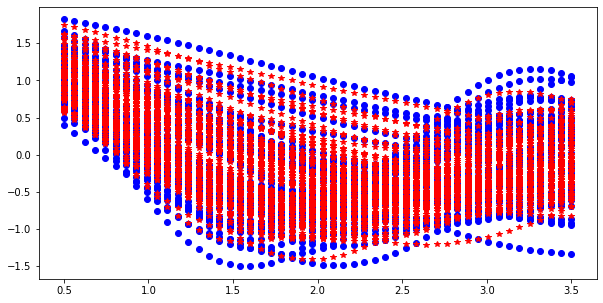

In [12]:
plt.figure(figsize=(10,5))

for i in range(0,num_samples,20):
    plt.plot(times,Q_samples_TS[i,0:num_time_obs],'bo')
    
for i in range(0,num_obs_samples,10):
    plt.plot(times,Q_obs_samples_TS[i,0:num_time_obs],'r*')

### Determining some QoI through L2 style projection to splines with N knots followed by PCA

In [13]:
from loq import *
time_start_idx = 20
time_end_idx = 49
learn = LoQ(Q_samples_TS, Q_obs_samples_TS, times)
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx, num_clean_obs=50, tol=1.0e-3, min_knots=5, max_knots=20)

0 5 0.02015255620772132
0 6 0.01329109671217717
0 7 0.00951519509643903
0 8 0.008198239945047075
0 9 0.006188528261412974
0 10 0.0047439305814178075
0 11 0.002973420218089007
0 12 0.002643477069510907
0 13 0.001931467522268711
0 14 0.0012567971332809198
0 15 0.0008785950778211711
0 15 knots being used.
1 5 0.008955139606330736
1 6 0.00582964341285233
1 7 0.004193518545314751
1 8 0.003053020366849812
1 9 0.002301244798490759
1 10 0.0016989915138040134
1 11 0.0011632001976361807
1 12 0.0009152274696809779
1 12 knots being used.
2 5 0.009583423348440983
2 6 0.005955130426039392
2 7 0.004332711158052425
2 8 0.003302467279234494
2 9 0.0026478689809314947
2 10 0.0019529585536819688
2 11 0.001296866186388451
2 12 0.0010214679123902368
2 13 0.0007939487886380354
2 13 knots being used.
3 5 0.015759224710672023
3 6 0.01117719156267565
3 7 0.008529131709262594
3 8 0.00794420044703672
3 9 0.005140605764400705
3 10 0.003919808773365715
3 11 0.002532755036050086
3 12 0.0021709419910479998
3 13 0.001

/Users/smattis/src/anaconda3/anaconda3/envs/loq.py/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


15 8 0.0027387224982914817
15 9 0.0019360144358279167
15 10 0.001449737829380107
15 11 0.0009818394901921449
15 11 knots being used.
16 5 0.003101596169228203
16 6 0.0020031166222175233
16 7 0.0014415190774811847
16 8 0.0010651615839149258
16 9 0.0007958499458649447
16 9 knots being used.
17 5 0.007541637031825784
17 6 0.004882309274940887
17 7 0.0035128809461265785
17 8 0.002578988057436276
17 9 0.0019343230584196877
17 10 0.0014342745240937854
17 11 0.0009747617182728744
17 11 knots being used.
18 5 0.009564731321744372
18 6 0.007609841364957033
18 7 0.0049450625559718875
18 8 0.0036565502776841952
18 9 0.002733084062608478
18 10 0.0020434952057299446
18 11 0.001410450388507204
18 12 0.0011667936742426172
18 13 0.0008591536269049406
18 13 knots being used.
19 5 0.005385134821446697
19 6 0.0034763331417402748
19 7 0.002501790999182468
19 8 0.0018503737470565685
19 9 0.0013817747804037452
19 10 0.0010284977777737156
19 11 0.0006944314015205614
19 11 knots being used.
20 5 0.01055271602

49 8 0.0035980479111305972
49 9 0.002562737026188532
49 10 0.0021019320979695968
49 11 0.0013026100358465042
49 12 0.0010255626683061585
49 13 0.0008194959762076493
49 13 knots being used.
50 5 0.008834967043183636
50 6 0.005718262438030969
50 7 0.004113950100533528
50 8 0.003012238089239107
50 9 0.002262742199152103
50 10 0.0016752098747269857
50 11 0.001141368469376841
50 12 0.0009008094616591218
50 12 knots being used.
51 5 0.009354997912716635
51 6 0.005953515087484804
51 7 0.004287698303205878
51 8 0.0032419877165821647
51 9 0.00239022911127933
51 10 0.0018005455029374764
51 11 0.0011915370747249154
51 12 0.0009576399571600999
51 12 knots being used.
52 5 0.010064255642242816
52 6 0.006534507675163659
52 7 0.004701116081255424
52 8 0.003438586453005709
52 9 0.0025846550741014654
52 10 0.0019126865602176553
52 11 0.0013042395578723197
52 12 0.0010288042625313226
52 13 0.0007624512728345627
52 13 knots being used.
53 5 0.0008259065026517462
53 5 knots being used.
54 5 0.018552716374

81 11 0.0016148914154081111
81 12 0.0013109645391795456
81 13 0.0010394433541929047
81 14 0.0007054301038303298
81 14 knots being used.
82 5 0.012941830500554969
82 6 0.009370850927238945
82 7 0.007425596941264722
82 8 0.006118724705563788
82 9 0.004164627042737695
82 10 0.0032105349478451
82 11 0.002086892013532274
82 12 0.001760845127123101
82 13 0.0014379647642827338
82 14 0.0010126320846133461
82 15 0.0006806188275413983
82 15 knots being used.
83 5 0.0066917113849457935
83 6 0.0057808135368193295
83 7 0.004062280068452367
83 8 0.0032073546487237543
83 9 0.0024183337234036967
83 10 0.0019077801955999709
83 11 0.0011812609466616344
83 12 0.0009466456937007329
83 12 knots being used.
84 5 0.013883840296508179
84 6 0.013504304162748752
84 7 0.007852462344742923
84 8 0.0069233486609609094
84 9 0.004885345537784628
84 10 0.0036201678585647884
84 11 0.002190912428814313
84 12 0.0020080138462870547
84 13 0.0015870374337160656
84 14 0.0010101127883244848
84 15 0.0007659310560409599
84 15 k

111 15 0.0008852730950453905
111 15 knots being used.
112 5 0.008567111062212049
112 6 0.005521697768943032
112 7 0.0039773865222774065
112 8 0.0029100503667998105
112 9 0.0021989761224249765
112 10 0.0016502346475468388
112 11 0.001142434122702924
112 12 0.000929489091320505
112 12 knots being used.
113 5 0.011273008343095834
113 6 0.00732154376404687
113 7 0.005266697714885204
113 8 0.003838815068830768
113 9 0.0028913762965031577
113 10 0.002135469864504387
113 11 0.0014608722825066617
113 12 0.0011500663403913387
113 13 0.0008508855631581288
113 13 knots being used.
114 5 0.010047707748451635
114 6 0.00657362208103606
114 7 0.004727075104191686
114 8 0.0033968223398742133
114 9 0.0025804374049254336
114 10 0.0018925217620221696
114 11 0.0013104952651525677
114 12 0.0010238225927120081
114 13 0.0007523074339771951
114 13 knots being used.
115 5 0.009827354390733812
115 6 0.006375200712784876
115 7 0.0045867726741756565
115 8 0.0033610997344008333
115 9 0.002523702063738348
115 10 0.

142 7 0.009414967232433326
142 8 0.008119380600624683
142 9 0.006084378223209153
142 10 0.004738293782237473
142 11 0.0030763856230696333
142 12 0.002481752753724669
142 13 0.0019262213295740994
142 14 0.0012392285894460373
142 15 0.0008877692111793255
142 15 knots being used.
143 5 0.007428224187907942
143 6 0.004843654142457567
143 7 0.0034840330411967696
143 8 0.00252914233902979
143 9 0.0019097083752467434
143 10 0.0014079777407799844
143 11 0.0009663078888052005
143 11 knots being used.
144 5 0.014079310160731778
144 6 0.00883489402375502
144 7 0.007539510176177999
144 8 0.006416254321233531
144 9 0.0044495965385014415
144 10 0.003280316991807144
144 11 0.002182399756679157
144 12 0.001966200199033125
144 13 0.0014340109969377228
144 14 0.001061096467780081
144 15 0.0007299546429494747
144 15 knots being used.
145 5 0.007450175024501738
145 6 0.00477950514762376
145 7 0.0034406632498799107
145 8 0.002568038567544492
145 9 0.001907572364250193
145 10 0.001426869783117492
145 11 0.0

175 15 0.000825404062618345
175 15 knots being used.
176 5 0.012088952856636671
176 6 0.009182982120691796
176 7 0.006709363891485867
176 8 0.0055601915807201455
176 9 0.004180525817176545
176 10 0.0030311674722341584
176 11 0.002012840646429909
176 12 0.0016870495262151857
176 13 0.0013440606694379413
176 14 0.0008525737412439476
176 14 knots being used.
177 5 0.010536877832018404
177 6 0.006484235999637971
177 7 0.004957175988248216
177 8 0.0036758013087581994
177 9 0.0027980441679433398
177 10 0.002182576030769354
177 11 0.001426617482428921
177 12 0.0011224729880359569
177 13 0.0008293568949913397
177 13 knots being used.
178 5 0.0070252858382991125
178 6 0.004564481773534515
178 7 0.0032837249566559936
178 8 0.002397729261234159
178 9 0.001804170189384139
178 10 0.0013340974789501042
178 11 0.0009109688258891264
178 11 knots being used.
179 5 0.011646507929774504
179 6 0.007728679749276594
179 7 0.006621660292229101
179 8 0.005732866806174219
179 9 0.004138887176050262
179 10 0.00

208 5 0.00913116895613581
208 6 0.005837594108715799
208 7 0.004199690020294128
208 8 0.0031275611451262457
208 9 0.0023071810185721475
208 10 0.0017393604144766044
208 11 0.0011896484937306351
208 12 0.0009188340503202094
208 12 knots being used.
209 5 0.008711047071402463
209 6 0.005611182059499472
209 7 0.0040373534233715536
209 8 0.0029701891957025837
209 9 0.0022248274945318993
209 10 0.0016509014439202226
209 11 0.0011203082117975725
209 12 0.000886439221648529
209 12 knots being used.
210 5 0.007276368368649951
210 6 0.004686242228210074
210 7 0.003372780272260488
210 8 0.0025001721000773905
210 9 0.00186459041610572
210 10 0.0013895950293055831
210 11 0.0009363095922140043
210 11 knots being used.
211 5 0.010672818250943213
211 6 0.00694825401967593
211 7 0.004998081984834647
211 8 0.003637757362857751
211 9 0.0027423922803006895
211 10 0.0020242230412264943
211 11 0.001386324971873346
211 12 0.0010905800282824858
211 13 0.0008063158843505909
211 13 knots being used.
212 5 0.01

241 6 0.01229449806293862
241 7 0.00930243814066957
241 8 0.0070813699484238955
241 9 0.005447028801837139
241 10 0.004619798864317624
241 11 0.002904164684047997
241 12 0.002383509077825924
241 13 0.0017332455605911891
241 14 0.0012854301734679255
241 15 0.0007843294848367186
241 15 knots being used.
242 5 0.009363738698544437
242 6 0.006038684315848654
242 7 0.004368264566673839
242 8 0.0031989234755239434
242 9 0.0024239973353071664
242 10 0.001820942095559076
242 11 0.0012615840181717558
242 12 0.000995966377394171
242 12 knots being used.
243 5 0.01597277569343324
243 6 0.010727821528896444
243 7 0.008774917575136444
243 8 0.007843931818852219
243 9 0.00554711490943489
243 10 0.004018676545264235
243 11 0.002651850010620213
243 12 0.0022375800178738867
243 13 0.0017691078069982256
243 14 0.0011046599372289685
243 15 0.0008376089745173671
243 15 knots being used.
244 5 0.011462139802327695
244 6 0.008573786618654865
244 7 0.006702313741648946
244 8 0.005536538001265461
244 9 0.0038

271 13 0.0018445349895297699
271 14 0.0012319418500374916
271 15 0.0007911132973853264
271 15 knots being used.
272 5 0.010075017311370955
272 6 0.00653576085613766
272 7 0.004702287239003235
272 8 0.003445796748467043
272 9 0.0025872700009746162
272 10 0.0019165184394620326
272 11 0.0013046819974176509
272 12 0.0010302163377645206
272 13 0.0007641737374671504
272 13 knots being used.
273 5 0.018790140173143996
273 6 0.01250121025662369
273 7 0.009181831646202442
273 8 0.006926454135194077
273 9 0.00543035770704895
273 10 0.004583479441909599
273 11 0.0030813588253944687
273 12 0.002385812126479448
273 13 0.001726239008583346
273 14 0.0012207431773627838
273 15 0.0008288116931910326
273 15 knots being used.
274 5 0.008917385138267961
274 6 0.005430210967117664
274 7 0.004092398170483221
274 8 0.003102149170614887
274 9 0.0022968363650287212
274 10 0.001761475965696496
274 11 0.0011973952428162187
274 12 0.0009429822830462958
274 12 knots being used.
275 5 0.00644420362643206
275 6 0.00

305 14 0.0012147706199189397
305 15 0.0008046066920749599
305 15 knots being used.
306 5 0.007344417205975402
306 6 0.004712396346173592
306 7 0.0033924874769810263
306 8 0.00253483143137146
306 9 0.0018817307611211993
306 10 0.0014083996871535847
306 11 0.0009421662286827878
306 11 knots being used.
307 5 0.008133666097656513
307 6 0.0052804922931931385
307 7 0.003798835540428915
307 8 0.0027745658002036647
307 9 0.0020873863552846104
307 10 0.0015436723632410105
307 11 0.0010538731191187258
307 12 0.0008306744321964352
307 12 knots being used.
308 5 0.0036791010146087462
308 6 0.0023839817173758084
308 7 0.0017150981343302867
308 8 0.0012546712793565487
308 9 0.0009429967090502483
308 9 knots being used.
309 5 0.003364263452260686
309 6 0.0021706924565604124
309 7 0.0015619162690434336
309 8 0.0011485099371679685
309 9 0.0008606150647512649
309 9 knots being used.
310 5 0.008224451981351388
310 6 0.006219779278417833
310 7 0.00414415151536766
310 8 0.003114771690548514
310 9 0.002321

343 8 0.00805943018008234
343 9 0.005842328974614406
343 10 0.004251485148945222
343 11 0.002890125846343848
343 12 0.0022370683730228015
343 13 0.001812199998921756
343 14 0.0012888448661849416
343 15 0.0008352486161418129
343 15 knots being used.
344 5 0.010922025132434194
344 6 0.007011641663220915
344 7 0.005047360143452215
344 8 0.0037640065741128556
344 9 0.0027973255505960907
344 10 0.002091365542498826
344 11 0.0014015973729523024
344 12 0.0011176205270897821
344 13 0.0008359528091701669
344 13 knots being used.
345 5 0.010432424280566838
345 6 0.008508184334202354
345 7 0.006316380424613304
345 8 0.005875738394812634
345 9 0.00380334679874589
345 10 0.002953945873957224
345 11 0.0018851693377906296
345 12 0.001619687332984544
345 13 0.0012596014727019344
345 14 0.000880716113253046
345 14 knots being used.
346 5 0.009686316720787902
346 6 0.006249491182057037
346 7 0.004496560732402533
346 8 0.003305833426251687
346 9 0.002477224240977242
346 10 0.0018376092249435298
346 11 0.

375 5 0.009748199698449981
375 6 0.006509478300901868
375 7 0.0050515566133863335
375 8 0.004080050256542709
375 9 0.002986220086511666
375 10 0.0022300871914963678
375 11 0.0015159729954541978
375 12 0.001263363640470786
375 13 0.0009507229290711437
375 13 knots being used.
376 5 0.0030154209785536817
376 6 0.0019110951186107747
376 7 0.0013960215949759538
376 8 0.0010304217461442292
376 9 0.0007704165769191165
376 9 knots being used.
377 5 0.016206211619564908
377 6 0.010867168401619776
377 7 0.008087045928312763
377 8 0.007123661202689765
377 9 0.004901117392159238
377 10 0.0037367561506241485
377 11 0.002449443219665012
377 12 0.0020513639420733816
377 13 0.001681934492888315
377 14 0.0011517946484373557
377 15 0.0007904224984518239
377 15 knots being used.
378 5 0.009740261889198729
378 6 0.006033387300150038
378 7 0.0046340697166194
378 8 0.0034432362451349723
378 9 0.0027551286327790873
378 10 0.0019797566576688036
378 11 0.0013205709821757776
378 12 0.001038469887515803
378 13 

408 5 0.016152240724415096
408 6 0.012342895925753689
408 7 0.009580512031483308
408 8 0.00793235602868214
408 9 0.005764984168829028
408 10 0.0041933560225342155
408 11 0.00283817664924499
408 12 0.0022084539302648465
408 13 0.0018073716417149974
408 14 0.001180209637495897
408 15 0.0008249239138826739
408 15 knots being used.
409 5 0.008433040377754678
409 6 0.005477373052529984
409 7 0.003940573425637094
409 8 0.0028810462630170157
409 9 0.002166163294427234
409 10 0.0016027423409672018
409 11 0.001093237379117839
409 12 0.0008621807225460484
409 12 knots being used.
410 5 0.007842297682738992
410 6 0.0050425162758158965
410 7 0.003645297037375133
410 8 0.002681322932829797
410 9 0.0020247506072586323
410 10 0.00152395725502247
410 11 0.0010036434091072824
410 12 0.0008520154483498386
410 12 knots being used.
411 5 0.005442878868101018
411 6 0.003525154501493283
411 7 0.002536352100902632
411 8 0.0018620045828834156
411 9 0.0013965585535604646
411 10 0.0010354132960701907
411 11 0.0

440 9 0.005495122287457451
440 10 0.004051967981622364
440 11 0.0029459268037113485
440 12 0.0021072132169080065
440 13 0.0017263100192675353
440 14 0.0011314390761094988
440 15 0.0008222071930459933
440 15 knots being used.
441 5 0.01064507750708908
441 6 0.00690454532471011
441 7 0.0049675809871550245
441 8 0.003640710325512056
441 9 0.002733346481218151
441 10 0.0020247234194327233
441 11 0.001378273134142832
441 12 0.001088376324015789
441 13 0.000807365450710492
441 13 knots being used.
442 5 0.007335834782480225
442 6 0.004748556853493214
442 7 0.003416881704890264
442 8 0.0025141814264588594
442 9 0.0018832176083852738
442 10 0.0013980584836715407
442 11 0.0009482271214063035
442 11 knots being used.
443 5 0.010886934173056941
443 6 0.006387856343045429
443 7 0.004677548181273168
443 8 0.0037768666974998706
443 9 0.0028333304800128634
443 10 0.0022331166214715754
443 11 0.0013818130834222678
443 12 0.0011936555532939686
443 13 0.0008642729128032899
443 13 knots being used.
444 5

472 10 0.002862487011614592
472 11 0.001847635097323398
472 12 0.0015853407461275447
472 13 0.0011838640886204913
472 14 0.0008547285657428392
472 14 knots being used.
473 5 0.009326434427438047
473 6 0.005975504358442417
473 7 0.004300387807361988
473 8 0.003189739454576055
473 9 0.002377669326177955
473 10 0.0017715075662406673
473 11 0.0011936851345688418
473 12 0.0009487257526997957
473 12 knots being used.
474 5 0.01145908928525694
474 6 0.007439536361850095
474 7 0.00535219487580777
474 8 0.003915150885180953
474 9 0.002942685926404108
474 10 0.002177629507133137
474 11 0.001484857993297371
474 12 0.0011713112556076169
474 13 0.0008680981124220652
474 13 knots being used.
475 5 0.014098192391302233
475 6 0.009120730948900212
475 7 0.006562607740269323
475 8 0.004826131578704729
475 9 0.0036159633105005604
475 10 0.0026830424769933386
475 11 0.0018210605786791326
475 12 0.00144069378049984
475 13 0.0010704590140373138
475 14 0.0007010728816670239
475 14 knots being used.
476 5 0.0

506 14 0.0007290657054002629
506 14 knots being used.
507 5 0.013014332641636752
507 6 0.008196221336781469
507 7 0.006002067731951362
507 8 0.004815369573788989
507 9 0.003546156446838172
507 10 0.002639067234669908
507 11 0.0018164766243058087
507 12 0.0015059064393431318
507 13 0.001125168347448789
507 14 0.0007876428840465744
507 14 knots being used.
508 5 0.004402416663447582
508 6 0.0028452017837146955
508 7 0.0020474835757611077
508 8 0.0015105322371022642
508 9 0.0011297172590642726
508 10 0.0008398993377824401
508 10 knots being used.
509 5 0.008323719804349122
509 6 0.005378798402673148
509 7 0.0038698986483361878
509 8 0.002838172908172762
509 9 0.002129924346519482
509 10 0.0015781942436863458
509 11 0.0010737342422350224
509 12 0.000848189609588901
509 12 knots being used.
510 5 0.014409640775395536
510 6 0.009682364665283806
510 7 0.008149024502347087
510 8 0.006846824934047369
510 9 0.004703345505382108
510 10 0.003908620599593173
510 11 0.0024184383031943877
510 12 0.00

538 15 0.0007662528487796509
538 15 knots being used.
539 5 0.013490347835373033
539 6 0.009898505253045703
539 7 0.007246884436267615
539 8 0.006467546796298245
539 9 0.004495861310157559
539 10 0.003386633591244135
539 11 0.0022422896054157385
539 12 0.0018551936615608076
539 13 0.0015276889930273788
539 14 0.0010391268213221436
539 15 0.0007191782845614794
539 15 knots being used.
540 5 0.018398587984228047
540 6 0.012485359199873005
540 7 0.009923646483019804
540 8 0.008655784829697347
540 9 0.005488638223282724
540 10 0.0045735142425263305
540 11 0.0030901791691400663
540 12 0.0024053014905476007
540 13 0.0018438549480246278
540 14 0.0012009795077698392
540 15 0.0008124445324805017
540 15 knots being used.
541 5 0.017068465337916408
541 6 0.011250351772363151
541 7 0.008631692432776799
541 8 0.006369808780924225
541 9 0.004939996473344455
541 10 0.0037332168185943747
541 11 0.0025432450272148688
541 12 0.0021390393439200744
541 13 0.0015855016450930194
541 14 0.001168961899744439


570 7 0.006383131085418433
570 8 0.0046596558729955165
570 9 0.0035064359914024094
570 10 0.0025916892614516965
570 11 0.0017706508276014435
570 12 0.0013950876294129295
570 13 0.0010329181125000992
570 14 0.0006721243674029223
570 14 knots being used.
571 5 0.01740555364025701
571 6 0.011282832621368274
571 7 0.010886313573920862
571 8 0.006691801137000032
571 9 0.005532007676951645
571 10 0.004628497431676109
571 11 0.002694740035972857
571 12 0.0022018893571146936
571 13 0.0018232171919304431
571 14 0.0011458243505068264
571 15 0.0007865925129442926
571 15 knots being used.
572 5 0.01044309364327062
572 6 0.0067831211214210265
572 7 0.0049374983615132605
572 8 0.0042307908376449
572 9 0.0029691488597022296
572 10 0.0022050470567260977
572 11 0.0015374877199921572
572 12 0.0012216131676610995
572 13 0.00088829837691658
572 13 knots being used.
573 5 0.011176183707572066
573 6 0.007237780668684148
573 7 0.005207820259511166
573 8 0.003828346957106788
573 9 0.002869118932456868
573 10 

600 10 0.0016482109843354517
600 11 0.0011300800711304994
600 12 0.0008883632850512579
600 12 knots being used.
601 5 0.006189428006103151
601 6 0.0040206904024382905
601 7 0.0028926355741575823
601 8 0.0021147249434357654
601 9 0.001590098525478083
601 10 0.001176593559915837
601 11 0.0008025248708408584
601 11 knots being used.
602 5 0.009664446828470329
602 6 0.006223090885776462
602 7 0.00447915588693164
602 8 0.003326845025049515
602 9 0.002478259890735163
602 10 0.0018488701856430292
602 11 0.0012435680080534746
602 12 0.0009893701154946879
602 12 knots being used.
603 5 0.006783022576302121
603 6 0.004405610543071951
603 7 0.003169261005910243
603 8 0.0023125498210003806
603 9 0.0017406950955095582
603 10 0.0012864096007843989
603 11 0.0008791383878055997
603 11 knots being used.
604 5 0.01980818682910167
604 6 0.013182522619833633
604 7 0.010353663099672021
604 8 0.008956305902472558
604 9 0.005736124828119785
604 10 0.004722657360011178
604 11 0.0031500720411768795
604 12 0.00

632 12 0.0010220972253755325
632 13 0.0007511162144092089
632 13 knots being used.
633 5 0.011346627259544977
633 6 0.007307405089762281
633 7 0.005259490388795522
633 8 0.0039038018828862747
633 9 0.0029091904418951007
633 10 0.002169569972929841
633 11 0.001460165279120909
633 12 0.0011612510034521403
633 13 0.0008666513711773706
633 13 knots being used.
634 5 0.010569805650051068
634 6 0.007072224444546978
634 7 0.005606782092739033
634 8 0.004052619243216583
634 9 0.00304028946792306
634 10 0.0022962785931608456
634 11 0.0015413245176886241
634 12 0.00126944396342553
634 13 0.000935980563170229
634 13 knots being used.
635 5 0.010492505814944878
635 6 0.006741455664705533
635 7 0.0048519029399339084
635 8 0.0035995020378730195
635 9 0.0026830411788808144
635 10 0.0019999313835211674
635 11 0.0013468990892127246
635 12 0.0010707712726964525
635 13 0.0007989315442140659
635 13 knots being used.
636 5 0.01445954052220382
636 6 0.009694232651300354
636 7 0.007503916984150906
636 8 0.00

663 10 0.0018504281073070986
663 11 0.0012675667545332411
663 12 0.000997015815793951
663 12 knots being used.
664 5 0.0076390868220856745
664 6 0.004983846699897254
664 7 0.003584776107686953
664 8 0.002599644157291815
664 9 0.001964125978369333
664 10 0.0014473509973568289
664 11 0.0009942070638858267
664 11 knots being used.
665 5 0.008416777686922934
665 6 0.005481445601856744
665 7 0.003942449442062326
665 8 0.002853364484529114
665 9 0.002158342647782867
665 10 0.0015887749866011598
665 11 0.0010933004833587753
665 12 0.0008574815251702392
665 12 knots being used.
666 5 0.014090129781424529
666 6 0.009966963018038896
666 7 0.007741709942680756
666 8 0.006911880415157285
666 9 0.0046647310049116805
666 10 0.0035644060087566395
666 11 0.0024010364267148154
666 12 0.0020275955510820182
666 13 0.001517474338666799
666 14 0.0010417254385432023
666 15 0.0007548195485870514
666 15 knots being used.
667 5 0.018443890923924518
667 6 0.009585010190760435
667 7 0.008186644632965492
667 8 0.

694 12 0.001290011280814651
694 13 0.0010195461431463883
694 14 0.0006522790017222637
694 14 knots being used.
695 5 0.010488848962346753
695 6 0.00808391253350582
695 7 0.0063893415847284816
695 8 0.005517145165728594
695 9 0.0037086313353064393
695 10 0.0030643929032243915
695 11 0.0019007279503512958
695 12 0.0016145531563560415
695 13 0.0012164678855460102
695 14 0.0009143473127369845
695 14 knots being used.
696 5 0.009076688108047563
696 6 0.005946937894512555
696 7 0.00427661965684727
696 8 0.003076804978182433
696 9 0.002335713809378206
696 10 0.0017142452180245705
696 11 0.0011856986113503293
696 12 0.0009269638151787313
696 12 knots being used.
697 5 0.007678284932083667
697 6 0.0049397576720475725
697 7 0.003555057409276052
697 8 0.0026325454497732595
697 9 0.001964449912269426
697 10 0.0014630229566422583
697 11 0.0009868305024200354
697 11 knots being used.
698 5 0.012209102786346734
698 6 0.009121878223857184
698 7 0.006512289976090426
698 8 0.005959522612284133
698 9 0.0

725 11 0.0010481637158352621
725 12 0.0008243360205409653
725 12 knots being used.
726 5 0.005043508651557687
726 6 0.0032521820064810754
726 7 0.00234037911409606
726 8 0.0017274974448289549
726 9 0.0012915846024068112
726 10 0.0009604611953130791
726 10 knots being used.
727 5 0.009363795371340404
727 6 0.006090878893381276
727 7 0.004381598884881882
727 8 0.0031945565391146256
727 9 0.0024058557295619965
727 10 0.0017775115732245861
727 11 0.001215440319565837
727 12 0.000957081234652577
727 12 knots being used.
728 5 0.009263030992850963
728 6 0.006015119170651746
728 7 0.004327478463740154
728 8 0.003165149519070451
728 9 0.0023792143300171782
728 10 0.0017607007402204674
728 11 0.001200592162592497
728 12 0.0009470412935588594
728 12 knots being used.
729 5 0.016697444197384594
729 6 0.011093876251126953
729 7 0.00828432062792162
729 8 0.0072659673351267535
729 9 0.005048296833558262
729 10 0.0038026028598135957
729 11 0.0025205075275600815
729 12 0.002088543393409138
729 13 0.00

757 10 0.002936562463770629
757 11 0.0018178465048827462
757 12 0.001530011037238842
757 13 0.001166408685761704
757 14 0.0008300077085073431
757 14 knots being used.
758 5 0.010858449789844538
758 6 0.006430818871409927
758 7 0.004744415991827347
758 8 0.003884378950350732
758 9 0.00286146417146391
758 10 0.0022748525406587504
758 11 0.0014148098919898097
758 12 0.0011339948291368735
758 13 0.0008722647053774616
758 13 knots being used.
759 5 0.011908556280667143
759 6 0.007715428010575449
759 7 0.0055511847078146825
759 8 0.004076139992707907
759 9 0.003056748686556122
759 10 0.0022662467086143833
759 11 0.001540282295764731
759 12 0.001217522717800568
759 13 0.00090398059613444
759 13 knots being used.
760 5 0.0015120625088836824
760 6 0.000980786291807234
760 6 knots being used.
761 5 0.013345433268359812
761 6 0.008637729546743664
761 7 0.0062150825348761185
761 8 0.004569743310709206
761 9 0.003424261496323891
761 10 0.0025406685882562448
761 11 0.001724629335224665
761 12 0.0013

789 7 0.006055344420765825
789 8 0.0047125254195760705
789 9 0.003805174443167495
789 10 0.0028018650125220305
789 11 0.0018250305435518817
789 12 0.0014691946955531733
789 13 0.00110968514389281
789 14 0.0007750301160670028
789 14 knots being used.
790 5 0.004395091280291624
790 6 0.00283589958966087
790 7 0.0020408637810740973
790 8 0.00150749453408432
790 9 0.0011266336338889658
790 10 0.0008381443560527742
790 10 knots being used.
791 5 0.012948007867803365
791 6 0.00991663508682017
791 7 0.007385359914376981
791 8 0.006379031333208651
791 9 0.004526968846985345
791 10 0.0033154968025781236
791 11 0.0022443671782833565
791 12 0.00185412387893075
791 13 0.001465935515682298
791 14 0.0009351111656846757
791 14 knots being used.
792 5 0.011734299946469948
792 6 0.009030145807747062
792 7 0.0066912401572794804
792 8 0.0057889564816500285
792 9 0.004096984047973427
792 10 0.003011019613989563
792 11 0.0018945975699049687
792 12 0.0016785480989390087
792 13 0.0013304159014829254
792 14 0

821 7 0.00818868918805985
821 8 0.007757939410896037
821 9 0.004982539345349449
821 10 0.0037080981506498
821 11 0.0024616382075896984
821 12 0.002129424233061466
821 13 0.001627727488076633
821 14 0.0011455013898870122
821 15 0.0008164865402030955
821 15 knots being used.
822 5 0.006528837572885654
822 6 0.004218477395317188
822 7 0.003035740733552767
822 8 0.0022412043850891725
822 9 0.001675439792923045
822 10 0.0012459443065903184
822 11 0.0008425791889448373
822 11 knots being used.
823 5 0.013303914756938484
823 6 0.009476249300503557
823 7 0.008099496890282906
823 8 0.0058847583257183285
823 9 0.004542506455771076
823 10 0.003240868279788345
823 11 0.0022079484623754165
823 12 0.0018064039484888884
823 13 0.0014518396796575558
823 14 0.0009780887608852003
823 14 knots being used.
824 5 0.008964577562926717
824 6 0.005868176521798399
824 7 0.004220039350290951
824 8 0.003037762017322603
824 9 0.0023053178786626603
824 10 0.0016924053010749314
824 11 0.0011700374046478411
824 12 0

853 8 0.00817482632464185
853 9 0.005742860214963228
853 10 0.004667931240016091
853 11 0.002952146010772033
853 12 0.002404057659309632
853 13 0.0016917012555052059
853 14 0.0011680855786661076
853 15 0.0007915641488713748
853 15 knots being used.
854 5 0.012063545899566253
854 6 0.007826104710726497
854 7 0.005630425847698649
854 8 0.00412413579747168
854 9 0.0030972595419366403
854 10 0.0022933594380156568
854 11 0.0015620998880777825
854 12 0.0012330904343249556
854 13 0.0009144592753278161
854 13 knots being used.
855 5 0.014143956708495156
855 6 0.01366242312359358
855 7 0.007918504096301855
855 8 0.006988255478579633
855 9 0.004899244856854428
855 10 0.003610740737849123
855 11 0.0022110629704553196
855 12 0.0020116232350918216
855 13 0.0016184284576912418
855 14 0.001001468990173542
855 15 0.0007529308034748986
855 15 knots being used.
856 5 0.016011747683271186
856 6 0.011087023321493599
856 7 0.007500379882348253
856 8 0.006874310637281879
856 9 0.005133970106040212
856 10 0.

884 12 0.0012829673918832868
884 13 0.0009434067043420794
884 13 knots being used.
885 5 0.011347485429943412
885 6 0.008534016005195303
885 7 0.006405470790285058
885 8 0.00549872370974533
885 9 0.0037847854138167865
885 10 0.0029304551571298363
885 11 0.0019256199254415415
885 12 0.0015691567414473585
885 13 0.0012382903870845174
885 14 0.0008530900172599829
885 14 knots being used.
886 5 0.015222473039980755
886 6 0.014816598855120187
886 7 0.008494760557159718
886 8 0.007542311320493784
886 9 0.0052814049682305365
886 10 0.003907378792952285
886 11 0.0026041650695904743
886 12 0.0021708152519535305
886 13 0.0017596807302421948
886 14 0.001080311651172374
886 15 0.0008197246804842043
886 15 knots being used.
887 5 0.01105774482027646
887 6 0.00712604506038714
887 7 0.0051271253541415795
887 8 0.003770397768409404
887 9 0.0028247675556455592
887 10 0.0020952552523006087
887 11 0.001422615029466415
887 12 0.0011253006895233272
887 13 0.000836104272235658
887 13 knots being used.
888 5

918 14 0.0009639636466713347
918 14 knots being used.
919 5 0.015991442744028
919 6 0.010400735993361922
919 7 0.007842888352729043
919 8 0.006827078329622595
919 9 0.004766477539321517
919 10 0.003580679908455262
919 11 0.0023706022413979007
919 12 0.00195891955081786
919 13 0.0016163291824090964
919 14 0.0011027222850310435
919 15 0.000764914950054158
919 15 knots being used.
920 5 0.006310979220888187
920 6 0.0040878638317683
920 7 0.0029411909632582867
920 8 0.0021567539042915665
920 9 0.0016187718659892677
920 10 0.0011996254006913956
920 11 0.0008160949118756422
920 11 knots being used.
921 5 0.007681073677606414
921 6 0.0050053355840245384
921 7 0.004084420178089902
921 8 0.002939043239513965
921 9 0.002168463584322292
921 10 0.001647439881285646
921 11 0.0010819508605069664
921 12 0.0008945210570416584
921 12 knots being used.
922 5 0.010503205738951606
922 6 0.00682235216611063
922 7 0.004944310732184766
922 8 0.003580085887367977
922 9 0.0027401282480554786
922 10 0.001989810

951 12 knots being used.
952 5 0.00921391296350187
952 6 0.00586959187272398
952 7 0.004226333658357793
952 8 0.0031756076342824993
952 9 0.0023323654564555802
952 10 0.0017659692963449209
952 11 0.0011781001488408772
952 12 0.0009316420824903244
952 12 knots being used.
953 5 0.009135887182554958
953 6 0.005958891814539977
953 7 0.004285823577776245
953 8 0.0031024003140858103
953 9 0.002346447866208387
953 10 0.00172727403429065
953 11 0.001188513160718024
953 12 0.000932216229553021
953 12 knots being used.
954 5 0.020395484631663716
954 6 0.013792511813006466
954 7 0.010604069923968387
954 8 0.007693894520061211
954 9 0.005928108692400483
954 10 0.0051817939599426875
954 11 0.0030663657872269322
954 12 0.002456642733479068
954 13 0.0019505804162183505
954 14 0.0012807028479277424
954 15 0.0008232574231681827
954 15 knots being used.
955 5 0.007242061462747236
955 6 0.004686027689991612
955 7 0.00337164444607378
955 8 0.0024753471135607417
955 9 0.0018565568774669631
955 10 0.001376

985 9 0.0022153002789130926
985 10 0.0016542117056482484
985 11 0.0011107749192550277
985 12 0.0008846786534741136
985 12 knots being used.
986 5 0.008733021393042587
986 6 0.005684404757792652
986 7 0.004087036727651767
986 8 0.0029588144601385043
986 9 0.0022377165850656607
986 10 0.0016473466045160844
986 11 0.0011333960597679819
986 12 0.0008890412518951547
986 12 knots being used.
987 5 0.01675301382882841
987 6 0.011755751368119835
987 7 0.010337767021093834
987 8 0.006407525754706735
987 9 0.004987212646815743
987 10 0.004393304105212296
987 11 0.002569560694795407
987 12 0.002096314544668636
987 13 0.001678267805775738
987 14 0.0010978843294441867
987 15 0.0007518800657332279
987 15 knots being used.
988 5 0.008653369076120508
988 6 0.005631704816554837
988 7 0.004051183271951219
988 8 0.002950829610181331
988 9 0.002223572129947398
988 10 0.001642046684579104
988 11 0.0011237411556736206
988 12 0.0008844138605561736
988 12 knots being used.
989 5 0.0179118610626647
989 6 0.011

19 7 0.00553528862473449
19 8 0.0041401461520592635
19 9 0.003098582558500261
19 10 0.0025146240453231294
19 11 0.00153109932085054
19 12 0.0013328515975518746
19 13 0.001024239891305893
19 14 0.0006722792111439135
19 14 knots being used.
20 5 0.009764976946081003
20 6 0.006236434270140849
20 7 0.004562837068926482
20 8 0.003307200771496948
20 9 0.002499313538593774
20 10 0.0018407044659241372
20 11 0.0012660645631128445
20 12 0.0009938277996824306
20 12 knots being used.
21 5 0.010772480501287568
21 6 0.00909853796088622
21 7 0.006532526084042566
21 8 0.005384987047386721
21 9 0.004043947346830384
21 10 0.002946669103659799
21 11 0.0019494178518142447
21 12 0.0016345933929181153
21 13 0.0013046020786254974
21 14 0.0008386914037680641
21 14 knots being used.
22 5 0.01450666915105229
22 6 0.011442627435020896
22 7 0.008468337498834575
22 8 0.007182604175647779
22 9 0.0046496233911418145
22 10 0.003857942063368735
22 11 0.0025305986784827854
22 12 0.0020421869622606276
22 13 0.0016111890

52 9 0.0017524664245621147
52 10 0.0012994820888825639
52 11 0.0008831353146882123
52 11 knots being used.
53 5 0.012018576525844258
53 6 0.009772186966748886
53 7 0.007296515588151482
53 8 0.006212963428118891
53 9 0.004235387645085198
53 10 0.003499759801112111
53 11 0.0021687424445225884
53 12 0.0018587260018864352
53 13 0.0013893426303062371
53 14 0.0009995693917124362
53 14 knots being used.
54 5 0.010210597962649177
54 6 0.006629222804797741
54 7 0.00476929197012928
54 8 0.0034892330084150052
54 9 0.002622381685059553
54 10 0.0019408433018274682
54 11 0.001323169020019325
54 12 0.0010438678743721899
54 13 0.0007736979927387436
54 13 knots being used.
55 5 0.01588869606197063
55 6 0.010882658998545175
55 7 0.008763942765338944
55 8 0.007372883098731922
55 9 0.00553422554611073
55 10 0.003992744260656936
55 11 0.0026530795151060394
55 12 0.0022282161695113
55 13 0.0018045075028544262
55 14 0.0010985836875398104
55 15 0.0008636393290451099
55 15 knots being used.
56 5 0.008280161394

85 7 0.00874665402726153
85 8 0.007999569143073778
85 9 0.005768624724062072
85 10 0.004525581381133
85 11 0.002921134736256947
85 12 0.002346335429840911
85 13 0.0016109199882390099
85 14 0.001178870547523055
85 15 0.0008113743445295208
85 15 knots being used.
86 5 0.009037217325944234
86 6 0.006401925045608321
86 7 0.0044926889498508185
86 8 0.0036358668206614617
86 9 0.002718504391284658
86 10 0.0021795658569014704
86 11 0.0014375389643651684
86 12 0.00114830600271612
86 13 0.0008160270547951664
86 13 knots being used.
87 5 0.010124878524158604
87 6 0.006567193262854389
87 7 0.004723724295551212
87 8 0.0034351811653054094
87 9 0.002590841058570602
87 10 0.0019111335862658394
87 11 0.0013101160433758917
87 12 0.0010300633766739055
87 13 0.0007612642611220997
87 13 knots being used.
88 5 0.012007073735973556
88 6 0.007007276760626035
88 7 0.005116848309245212
88 8 0.004137088394149675
88 9 0.0029523885854710057
88 10 0.0024131002150594633
88 11 0.0014990725582139936
88 12 0.0011782253

116 11 0.0012468085215850007
116 12 0.0010059553716734847
116 13 0.0007529797895761206
116 13 knots being used.
117 5 0.009200106845151105
117 6 0.0059368472959076355
117 7 0.00427270454677048
117 8 0.003162958575005496
117 9 0.002360783327275604
117 10 0.001758167340669145
117 11 0.0011860656788672806
117 12 0.000941873908765661
117 12 knots being used.
118 5 0.0106347111429341
118 6 0.008469818068245287
118 7 0.00554952545690493
118 8 0.004040793042676221
118 9 0.0030450058810727117
118 10 0.0022739169003937673
118 11 0.001483179311870096
118 12 0.0012812551375486158
118 13 0.000975352955406856
118 13 knots being used.
119 5 0.008761136460056532
119 6 0.008761136500685475
119 7 0.005397294838843805
119 8 0.004687034017443846
119 9 0.0033629444192174516
119 10 0.0024845850154114678
119 11 0.0015332756874399064
119 12 0.0013177892242147527
119 13 0.001066606269564485
119 14 0.0007512137201273565
119 14 knots being used.
120 5 0.013023870496980174
120 6 0.010042261750989599
120 7 0.0076

148 9 0.0031228698158496607
148 10 0.0024289836597589935
148 11 0.001478897662972597
148 12 0.0012589464613800094
148 13 0.0009472182331782596
148 13 knots being used.
149 5 0.007756269453873379
149 6 0.004986569412953532
149 7 0.0035889648945636693
149 8 0.002662537285409939
149 9 0.001984710352362446
149 10 0.0014795902417802883
149 11 0.0009963378379928118
149 11 knots being used.
150 5 0.009377490571815169
150 6 0.007803748868426447
150 7 0.005334846528056167
150 8 0.00422926508844707
150 9 0.003197529694891105
150 10 0.002491514110807723
150 11 0.0016069822213517857
150 12 0.0012886697376164728
150 13 0.0009685917184586358
150 13 knots being used.
151 5 0.015376862365362903
151 6 0.010374154041459856
151 7 0.008236157495355506
151 8 0.007369474049826888
151 9 0.004986109002526121
151 10 0.00414755039349328
151 11 0.002560178659033977
151 12 0.002166752944381803
151 13 0.0016174739394637745
151 14 0.00108620143767889
151 15 0.0008161400821015656
151 15 knots being used.
152 5 0.010

178 6 0.00741596627247155
178 7 0.0053360841423007455
178 8 0.003924524054139105
178 9 0.0029403448082519993
178 10 0.0021820696477084043
178 11 0.0014807567504960888
178 12 0.001171583431602756
178 13 0.0008705496488603005
178 13 knots being used.
179 5 0.00854168393961537
179 6 0.005507209092898553
179 7 0.0039624285164658836
179 8 0.002911392792344197
179 9 0.002182436320453934
179 10 0.0016184649990778565
179 11 0.0010994682664910301
179 12 0.0008693608091519242
179 12 knots being used.
180 5 0.006561617181154867
180 6 0.004251239994991718
180 7 0.0030588322095354294
180 8 0.0022450952298786147
180 9 0.0016841676663991209
180 10 0.0012487211319013904
180 11 0.000848777620474568
180 11 knots being used.
181 5 0.00758965815382077
181 6 0.004891173177521227
181 7 0.003520206645456777
181 8 0.002607747297322588
181 9 0.001945568287247971
181 10 0.0014494538477443303
181 11 0.0009772074040867885
181 11 knots being used.
182 5 0.0055975987491130525
182 6 0.003596934460900928
182 7 0.0025

210 8 0.0026178670902082127
210 9 0.0019684972299088377
210 10 0.001456379768938236
210 11 0.000993540549182987
210 11 knots being used.
211 5 0.009414713101677793
211 6 0.006040641881931261
211 7 0.0044729002642789365
211 8 0.0037483932997235065
211 9 0.0026718273311448597
211 10 0.0019759720989975748
211 11 0.0013294195354841343
211 12 0.0010798740484086072
211 13 0.0007903380244924118
211 13 knots being used.
212 5 0.01248898131021052
212 6 0.008064070610465653
212 7 0.005802526339040854
212 8 0.004273312589783362
212 9 0.0031990251533544826
212 10 0.0023753726827409204
212 11 0.0016102379873255597
212 12 0.0012749036524905915
212 13 0.0009479255535928841
212 13 knots being used.
213 5 0.017745077094720455
213 6 0.01202293451887078
213 7 0.00934607779149957
213 8 0.0067999763744852676
213 9 0.005325418773036489
213 10 0.004074644544509921
213 11 0.0027075456711834556
213 12 0.002180441319626779
213 13 0.0017209011039745108
213 14 0.001169420639597777
213 15 0.0007717413285286605
213

241 12 0.0017551115344279866
241 13 0.001320872022911398
241 14 0.00094671540676628
241 14 knots being used.
242 5 0.013179964246237921
242 6 0.008528702970107238
242 7 0.006136451980686366
242 8 0.004508287864402845
242 9 0.0033797842784326895
242 10 0.002506505375641757
242 11 0.001702729979762503
242 12 0.0013463423712612446
242 13 0.000999883635050024
242 13 knots being used.
243 5 0.009454926968949472
243 6 0.006088637335215433
243 7 0.0043821492757124365
243 8 0.0032110065187035274
243 9 0.002400576548350518
243 10 0.0017983959387799983
243 11 0.0012354344225499355
243 12 0.0009683991844736554
243 12 knots being used.
244 5 0.01571799663950112
244 6 0.010369985012921669
244 7 0.007365379669755288
244 8 0.00693787525303684
244 9 0.004997250215267539
244 10 0.003937563349645317
244 11 0.0025165695656634334
244 12 0.0020363889418577043
244 13 0.0015988655586009167
244 14 0.0010399978285737773
244 15 0.0007403861299104976
244 15 knots being used.
245 5 0.014430776251258038
245 6 0.00

272 12 0.0008851128983715052
272 12 knots being used.
273 5 0.009618457805271294
273 6 0.00625640500574664
273 7 0.004500423667055181
273 8 0.0032759142549288306
273 9 0.002469440010738688
273 10 0.0018228398106691437
273 11 0.0012482926998799424
273 12 0.000982051104107795
273 12 knots being used.
274 5 0.011075084732714378
274 6 0.008957105584613259
274 7 0.006755448034978072
274 8 0.00576296610424091
274 9 0.004008660949195367
274 10 0.0030855368648875217
274 11 0.0019852792349843856
274 12 0.001700402445284855
274 13 0.0013216167456884735
274 14 0.0009211544592947875
274 14 knots being used.
275 5 0.00740496498504983
275 6 0.004809214939868748
275 7 0.003459936033437211
275 8 0.002530308268848564
275 9 0.0019021830215968758
275 10 0.0014076925712454762
275 11 0.000959917524202345
275 11 knots being used.
276 5 0.010442484074576791
276 6 0.007311956169184038
276 7 0.005822817632390503
276 8 0.004943092500524634
276 9 0.0035034717142813196
276 10 0.0028832212474862993
276 11 0.001722

304 7 0.008535667103167634
304 8 0.008049886637055177
304 9 0.0054044134411469205
304 10 0.0039309225049245595
304 11 0.0025783079464006095
304 12 0.002182085550021073
304 13 0.0017237491878319845
304 14 0.0010814572560763356
304 15 0.0008283957475926955
304 15 knots being used.
305 5 0.0070047587274370635
305 6 0.004517288620531863
305 7 0.003251148681818577
305 8 0.0024084124921678603
305 9 0.0017968840374079462
305 10 0.0013387575889308736
305 11 0.0009025301085584341
305 11 knots being used.
306 5 0.005591969673355255
306 6 0.003620941807915485
306 7 0.002605333362018253
306 8 0.0019122278939142682
306 9 0.0014344807187436357
306 10 0.001063617052400219
306 11 0.0007229435102780412
306 11 knots being used.
307 5 0.011728007303827242
307 6 0.009139692474530087
307 7 0.007186134598479981
307 8 0.0062119858456445715
307 9 0.004167019029251268
307 10 0.0034427601883590523
307 11 0.0021407927403987786
307 12 0.001810565461078171
307 13 0.0013679905335444295
307 14 0.001008446505870423
3

335 10 0.003937622375813119
335 11 0.0026352867666219913
335 12 0.0022019245676499167
335 13 0.0017550875353498597
335 14 0.0010855398804783698
335 15 0.0008072634747897714
335 15 knots being used.
336 5 0.009715412772478374
336 6 0.006360091636535005
336 7 0.005235590379083621
336 8 0.003723094212094147
336 9 0.0027617532078738935
336 10 0.002085623404069407
336 11 0.0013796121006141111
336 12 0.0011370577307770456
336 13 0.0008437534201738467
336 13 knots being used.
337 5 0.008317253627053281
337 6 0.005383925351483734
337 7 0.0038739430510261806
337 8 0.0028478105552787866
337 9 0.0021342857283552664
337 10 0.0015836175945096332
337 11 0.0010750122635064725
337 12 0.0008503611108319695
337 12 knots being used.
338 5 0.008070428700095309
338 6 0.005248785167344431
338 7 0.003775871723583803
338 8 0.0027533955371333006
338 9 0.0020734334406212213
338 10 0.0015321309958933299
338 11 0.0010474360216409697
338 12 0.000824885387809249
338 12 knots being used.
339 5 0.008420014366388154
3

367 9 0.0014309646712879764
367 10 0.0010639399050931663
367 11 0.0007197675547539859
367 11 knots being used.
368 5 0.00610327538829106
368 6 0.003933812702981369
368 7 0.002831254629700792
368 8 0.0020985742320674236
368 9 0.0015651790550209503
368 10 0.0011664585290579095
368 11 0.0007859837161495707
368 11 knots being used.
369 5 0.007581561539268947
369 6 0.004930981148371991
369 7 0.0035471831025549287
369 8 0.0025849309780492506
369 9 0.0019473307846376762
369 10 0.0014384550178555716
369 11 0.0009839682314752509
369 11 knots being used.
370 5 0.008560573875866333
370 6 0.005551620415321738
370 7 0.003994035805682897
370 8 0.002922276748776786
370 9 0.002196177085405089
370 10 0.001625467711491715
370 11 0.0011080893750755215
370 12 0.000874224658661447
370 12 knots being used.
371 5 0.01036304640813793
371 6 0.00841795532693928
371 7 0.006207541978773838
371 8 0.00535438778227133
371 9 0.003741125028328293
371 10 0.002779782997181689
371 11 0.001853758780299934
371 12 0.0015950

398 13 0.0008072842662155837
398 13 knots being used.
399 5 0.008438987991347463
399 6 0.006994571546002747
399 7 0.004831141078979173
399 8 0.0037647576398864187
399 9 0.0028863671510472038
399 10 0.002167769098137647
399 11 0.0014214851503248343
399 12 0.0011622931711550756
399 13 0.0008790497470291393
399 13 knots being used.
400 5 0.010208091520633632
400 6 0.007955557359664158
400 7 0.005221045394383679
400 8 0.003863400208415769
400 9 0.0029120023674837686
400 10 0.002185420694268272
400 11 0.001543619099826967
400 12 0.0012516468513136527
400 13 0.0009025657375328136
400 13 knots being used.
401 5 0.011968744501746408
401 6 0.007695852138536194
401 7 0.00553915038561729
401 8 0.004114627480590752
401 9 0.003064833333595588
401 10 0.0022864413593201953
401 11 0.001537838102362145
401 12 0.0012235290138138978
401 13 0.0009134701171833239
401 13 knots being used.
402 5 0.007486063332490098
402 6 0.004820730253889478
402 7 0.0034688116150629667
402 8 0.002555295627215058
402 9 0.001

430 11 0.0009713821884799052
430 11 knots being used.
431 5 0.009187216473357242
431 6 0.005883015530560608
431 7 0.0042567706336019
431 8 0.0031597285179491663
431 9 0.002372894315923305
431 10 0.001789778782455746
431 11 0.0011754240417395732
431 12 0.0009898857153785774
431 12 knots being used.
432 5 0.00873103440909262
432 6 0.0056402008266271605
432 7 0.004058161859547366
432 8 0.002981246552748149
432 9 0.002235074519635123
432 10 0.0016575424046241175
432 11 0.0011260524728880657
432 12 0.0008903420774046669
432 12 knots being used.
433 5 0.01703807655382788
433 6 0.011771804014526306
433 7 0.00888978838063191
433 8 0.007172084433927868
433 9 0.005016747932085167
433 10 0.0039305376270014495
433 11 0.0025844075305372274
433 12 0.0023077037599045567
433 13 0.0016865251627140889
433 14 0.0011320597879089626
433 15 0.0008274945382979485
433 15 knots being used.
434 5 0.015727983870108115
434 6 0.012249840858572263
434 7 0.009353331971733278
434 8 0.007840787752388475
434 9 0.005674

464 6 0.005268944159079418
464 7 0.0037908259628797714
464 8 0.002777071711401065
464 9 0.0020855264135245066
464 10 0.0015446362324108111
464 11 0.001051780508521143
464 12 0.0008303876530011654
464 12 knots being used.
465 5 0.008922489769950168
465 6 0.005719978056042109
465 7 0.004130876026548387
465 8 0.0030557072648750637
465 9 0.0022959448717128133
465 10 0.001728865909774062
465 11 0.001184398029803319
465 12 0.0009612262782903972
465 12 knots being used.
466 5 0.011877089783502602
466 6 0.007693644572320447
466 7 0.005535712744212957
466 8 0.004067162284683488
466 9 0.0030490546157815068
466 10 0.002261516722972467
466 11 0.0015360784369397185
466 12 0.0012146586623212594
466 13 0.0009021127473097815
466 13 knots being used.
467 5 0.011702866834233206
467 6 0.007499074628988743
467 7 0.005398687826445833
467 8 0.004036033694247358
467 9 0.0029951644237535607
467 10 0.0022422969494630546
467 11 0.0014993524885733931
467 12 0.0011972575691692915
467 13 0.0008965765460777514
467 

494 10 0.004666441932366543
494 11 0.002708205736683081
494 12 0.0022098798865542945
494 13 0.0017693176221927022
494 14 0.0011954252723318753
494 15 0.0007987037313928081
494 15 knots being used.
495 5 0.009516923706833784
495 6 0.006229912094006691
495 7 0.004479981038666114
495 8 0.0032199376643049075
495 9 0.00244579701346409
495 10 0.0017940861886838095
495 11 0.0012420225227583023
495 12 0.0009704658853983535
495 12 knots being used.
496 5 0.007890412853083294
496 6 0.005116512301981511
496 7 0.003681272078582564
496 8 0.0026994410138875863
496 9 0.002026073467465064
496 10 0.0015013971695549038
496 11 0.001021434803617072
496 12 0.0008068713652540462
496 12 knots being used.
497 5 0.009157427722382365
497 6 0.0059263063932284265
497 7 0.004263965622642046
497 8 0.0031299607661701497
497 9 0.0023477038798539883
497 10 0.0017404805504734507
497 11 0.0011831369271433018
497 12 0.0009350971461441069
497 12 knots being used.
498 5 0.012970739676310118
498 6 0.00687567437631826
498 7 

523 9 0.0023717428950468223
523 10 0.0017702075289253224
523 11 0.0011988269012675956
523 12 0.0009622625995660229
523 12 knots being used.
524 5 0.01575273701126978
524 6 0.010488330557949975
524 7 0.007837717917639498
524 8 0.006887273245675608
524 9 0.004747357473644486
524 10 0.0036172356772530157
524 11 0.002367993806811782
524 12 0.001981729353889886
524 13 0.0016262898074005223
524 14 0.0011158251206351121
524 15 0.0007714765201358428
524 15 knots being used.
525 5 0.012688971746821003
525 6 0.00976919255785428
525 7 0.007582582456642289
525 8 0.0063766992711431145
525 9 0.004301792960126798
525 10 0.0033581085422353008
525 11 0.0021470088181722636
525 12 0.0018337635436949293
525 13 0.0014867740349125951
525 14 0.0010392681141610334
525 15 0.0007088334529416081
525 15 knots being used.
526 5 0.008426368541231464
526 6 0.005482446015908942
526 7 0.003943666024683192
526 8 0.0028687223755833173
526 9 0.002163394330107166
526 10 0.00159650914960652
526 11 0.0010938532534475768
526

553 5 0.010346874626344796
553 6 0.008650491275361168
553 7 0.006343184373382789
553 8 0.005481594066285942
553 9 0.0038764107048542967
553 10 0.0028550364381425613
553 11 0.0017995068887994249
553 12 0.0015881104011839045
553 13 0.0012847740037142822
553 14 0.0008128236895647525
553 14 knots being used.
554 5 0.007900435539270776
554 6 0.005112866685406816
554 7 0.003678605790109547
554 8 0.0026974655827848764
554 9 0.0020245616369333435
554 10 0.0015001539745045699
554 11 0.0010206756113302208
554 12 0.0008062417495293207
554 12 knots being used.
555 5 0.008758876136030401
555 6 0.00565784087068825
555 7 0.004070941013299102
555 8 0.00299258744171112
555 9 0.0022427224450723114
555 10 0.0016638080056528167
555 11 0.0011296363881016247
555 12 0.0008935051471160368
555 12 knots being used.
556 5 0.008251692415556497
556 6 0.005358907240654034
556 7 0.003855048574516292
556 8 0.002811205682453192
556 9 0.002116892977410292
556 10 0.0015641393751758277
556 11 0.001069380696285781
556 12 

585 9 0.004806466228988178
585 10 0.003594958524644523
585 11 0.002482380891409813
585 12 0.001859938655585676
585 13 0.0015347062066053887
585 14 0.0009977877079669617
585 14 knots being used.
586 5 0.007514995635241804
586 6 0.004868788520697817
586 7 0.0035029829946428433
586 8 0.0025677667821627052
586 9 0.0019276450570965351
586 10 0.00142814102607225
586 11 0.0009719412101783931
586 11 knots being used.
587 5 0.00898838900077931
587 6 0.006179886068095576
587 7 0.005561973809146818
587 8 0.004192870832550985
587 9 0.0028636684173623194
587 10 0.0022854744349278416
587 11 0.0014454276188601103
587 12 0.0011798704392033353
587 13 0.0009382587291628116
587 13 knots being used.
588 5 0.009802370767005072
588 6 0.006316517518526208
588 7 0.004546271847080879
588 8 0.0033731906917368864
588 9 0.0025143245819263032
588 10 0.0018747889404137684
588 11 0.0012621456969492525
588 12 0.0010035765327046054
588 13 0.000748848783601315
588 13 knots being used.
589 5 0.010693658686882327
589 6 0

618 11 0.0018005261542007654
618 12 0.0014633464779455756
618 13 0.0011490853569378326
618 14 0.0007569089020193389
618 14 knots being used.
619 5 0.014169664990402533
619 6 0.008524308073406543
619 7 0.006830819014932662
619 8 0.005758472524360671
619 9 0.0040871053415198295
619 10 0.003117717041680406
619 11 0.002012503211072682
619 12 0.0016409130422618506
619 13 0.0013100802423694298
619 14 0.0008533214370754397
619 14 knots being used.
620 5 0.008762395687734768
620 6 0.005715410485792224
620 7 0.004110914709890772
620 8 0.0029811166341470823
620 9 0.002252326198451131
620 10 0.0016595440673860542
620 11 0.0011401003669483849
620 12 0.0008951257729904231
620 12 knots being used.
621 5 0.007735557323260137
621 6 0.005037632519613204
621 7 0.0036236389320678814
621 8 0.002633248555805379
621 9 0.001987052065770355
621 10 0.001465718404602467
621 11 0.0010050613915728154
621 12 0.0007900188703046603
621 12 knots being used.
622 5 0.008361971552026512
622 6 0.005510090556641196
622 7 

649 12 0.0022900908006220785
649 13 0.0016955520592457352
649 14 0.0012710963628430921
649 15 0.0007726766937725101
649 15 knots being used.
650 5 0.009113547601198662
650 6 0.005859734865711975
650 7 0.004229708744026102
650 8 0.003111230815997117
650 9 0.0023457062755412915
650 10 0.0017630059172040898
650 11 0.001161020071042789
650 12 0.0009596944435517173
650 12 knots being used.
651 5 0.007437476188501275
651 6 0.004826159640847621
651 7 0.0034720603807242667
651 8 0.002540017310352083
651 9 0.0019090211141725912
651 10 0.0014127321963446386
651 11 0.0009632509048664739
651 11 knots being used.
652 5 0.009052507496236057
652 6 0.005909366736270849
652 7 0.004249989877584759
652 8 0.003069893899817539
652 9 0.0023248505398069503
652 10 0.0017095871757997984
652 11 0.0011784835774552845
652 12 0.0009232910502478814
652 12 knots being used.
653 5 0.008605855216818352
653 6 0.007017817275852921
653 7 0.005065643975059622
653 8 0.003944718744229768
653 9 0.002857264335230525
653 10 0.

682 7 0.005922658760159195
682 8 0.004171986563280909
682 9 0.0030374619266350586
682 10 0.0023489909381597014
682 11 0.0015362673365920381
682 12 0.0012473310532844179
682 13 0.0009872392529916385
682 13 knots being used.
683 5 0.01228342619533338
683 6 0.009255654343136013
683 7 0.007379810249102844
683 8 0.00605429547460868
683 9 0.0042721659850073505
683 10 0.003532028440254111
683 11 0.002198976832373194
683 12 0.0018584530848548895
683 13 0.0013983118953660644
683 14 0.0009450955396217506
683 14 knots being used.
684 5 0.009294033113084497
684 6 0.006069288878335532
684 7 0.004364971234899821
684 8 0.0031523551084255853
684 9 0.0023875562321829242
684 10 0.0017554956463504221
684 11 0.0012103519712670565
684 12 0.0009481537031090745
684 12 knots being used.
685 5 0.011736707580928487
685 6 0.0076198337805944765
685 7 0.00548157153119659
685 8 0.0040027531990059146
685 9 0.003011603498887801
685 10 0.0022264308386006045
685 11 0.0015206049207820167
685 12 0.0011983101789068242
685

711 13 0.001433458329383961
711 14 0.0010309030936016318
711 15 0.0007157820634627424
711 15 knots being used.
712 5 0.008287664572053205
712 6 0.005335714398522897
712 7 0.0038402474368957463
712 8 0.00284769010211155
712 9 0.002123319690334577
712 10 0.0015826749383445746
712 11 0.001066094656823104
712 12 0.0008473963965700693
712 12 knots being used.
713 5 0.009926404643718191
713 6 0.006369861644473486
713 7 0.004581355309843203
713 8 0.00339081797627202
713 9 0.0025088190250281573
713 10 0.001887630829507867
713 11 0.001274908537788643
713 12 0.0009978948931421746
713 12 knots being used.
714 5 0.011520511170119785
714 6 0.006635224674107406
714 7 0.004910816473353225
714 8 0.0038571803388466044
714 9 0.0030734267971552127
714 10 0.0022683903422077503
714 11 0.001426392977502265
714 12 0.001192113538402806
714 13 0.0008992521610491426
714 13 knots being used.
715 5 0.008488712306369524
715 6 0.005534977625660182
715 7 0.003980969729633087
715 8 0.0028818231543441064
715 9 0.00217

745 12 0.00204990790115616
745 13 0.0015084744049685794
745 14 0.0010057746757026252
745 15 0.0007463845323302032
745 15 knots being used.
746 5 0.009803640528742674
746 6 0.006351782535679838
746 7 0.0045702465587929356
746 8 0.0033570769690547475
746 9 0.0025170990642392308
746 10 0.0018668950057083267
746 11 0.0012681885175011068
746 12 0.0010027352509435004
746 13 0.000744643481845376
746 13 knots being used.
747 5 0.019762077886992444
747 6 0.01298951399633553
747 7 0.010061084973826144
747 8 0.008389113452985694
747 9 0.005916890255998952
747 10 0.004632163625055819
747 11 0.0030456424053881335
747 12 0.002463683835343131
747 13 0.0016021574604073688
747 14 0.001203984969403854
747 15 0.00078126667063979
747 15 knots being used.
748 5 0.010407092582822089
748 6 0.006612645853305259
748 7 0.004828693063408805
748 8 0.003541783304785069
748 9 0.0026575370911026065
748 10 0.001968573512784747
748 11 0.0013396559812529666
748 12 0.001058168648580709
748 13 0.0007852573788466407
748 1

777 7 0.0037143888559715726
777 8 0.002704860828343715
777 9 0.0020385135911169102
777 10 0.0015051911034793773
777 11 0.00103030736399134
777 12 0.0008107699563094768
777 12 knots being used.
778 5 0.008731217301915834
778 6 0.005667978665422368
778 7 0.004077587714807276
778 8 0.0029791384041869796
778 9 0.002240813405738639
778 10 0.0016572874920121718
778 11 0.0011311999886510441
778 12 0.0008917563668593865
778 12 knots being used.
779 5 0.006605266480582612
779 6 0.004273744940860733
779 7 0.0030751534487052537
779 8 0.002260974387598564
779 9 0.0016943307023947988
779 10 0.0012573175179658258
779 11 0.0008533621179981992
779 11 knots being used.
780 5 0.008572980906417189
780 6 0.005581588995571208
780 7 0.004014699256877053
780 8 0.002912614515938103
780 9 0.002199990421504898
780 10 0.0016213183465906323
780 11 0.0011134329233848282
780 12 0.0008743909661259069
780 12 knots being used.
781 5 0.007091629829203997
781 6 0.004598911759223957
781 7 0.003308597656813177
781 8 0.002

809 5 0.007631970586523361
809 6 0.004955641388415676
809 7 0.0035653127732732225
809 8 0.002608324607679909
809 9 0.0019604042792928694
809 10 0.001451039592846407
809 11 0.0009891668179787718
809 11 knots being used.
810 5 0.008884768712166808
810 6 0.005720753461707954
810 7 0.004117577305315143
810 8 0.0030575423813601187
810 9 0.0022779871322880776
810 10 0.0016992842241172988
810 11 0.0011431753814841984
810 12 0.0009093847178672126
810 12 knots being used.
811 5 0.012315668159269755
811 6 0.011586671016337164
811 7 0.00712432426296766
811 8 0.006129195721446174
811 9 0.004374161943246471
811 10 0.003219745438691639
811 11 0.0022302567718098867
811 12 0.0017034278835600756
811 13 0.0013844972452844414
811 14 0.0009105761678047438
811 14 knots being used.
812 5 0.008380302454928795
812 6 0.007173657590302262
812 7 0.005052990805645385
812 8 0.0037412983786908193
812 9 0.0029480398535426176
812 10 0.0022484708906609584
812 11 0.0013878689100782961
812 12 0.0011747097945078644
812 1

839 13 0.0008535496943743457
839 13 knots being used.
840 5 0.007876571665107995
840 6 0.006497195507234271
840 7 0.004497488043339089
840 8 0.0035114161562656383
840 9 0.0026910297587901836
840 10 0.0020245328684663937
840 11 0.0013225790344533177
840 12 0.0010832534680374135
840 13 0.0008203627266733344
840 13 knots being used.
841 5 0.007954964713913569
841 6 0.0051605915660743905
841 7 0.003712439250489579
841 8 0.0027086466742120637
841 9 0.002039021452852429
841 10 0.0015070091679011146
841 11 0.001029844469303073
841 12 0.0008112510116847939
841 12 knots being used.
842 5 0.0087761261369003
842 6 0.005682700708277912
842 7 0.004088963076746163
842 8 0.003006500511971183
842 9 0.00225295242825204
842 10 0.001671887283660906
842 11 0.001134697390945201
842 12 0.0008976857068899696
842 12 knots being used.
843 5 0.009125475563896536
843 6 0.005832322411774238
843 7 0.004207046835805426
843 8 0.0031291186024083764
843 9 0.002340246024466414
843 10 0.0017645305931390679
843 11 0.0012

872 12 0.002174233300633602
872 13 0.0017648311726110022
872 14 0.0010785211850313956
872 15 0.0008643711710378976
872 15 knots being used.
873 5 0.011641436626815297
873 6 0.006670152319988958
873 7 0.004866525305381979
873 8 0.0038890169791330935
873 9 0.003009591055682746
873 10 0.0022747343462938873
873 11 0.0014311333609982018
873 12 0.001196497451940262
873 13 0.0009026857742807935
873 13 knots being used.
874 5 0.005573657609041354
874 6 0.00360981421148505
874 7 0.00259732505343007
874 8 0.0019086921350218772
874 9 0.0014307098347184286
874 10 0.0010612495456589382
874 11 0.0007207190807204006
874 11 knots being used.
875 5 0.013600059312773888
875 6 0.00970357217941424
875 7 0.006978006587479011
875 8 0.0063399082700626806
875 9 0.004374771422296739
875 10 0.003324485904629734
875 11 0.002181921671416517
875 12 0.0018161353853775616
875 13 0.0014916891883431469
875 14 0.0010198065924009274
875 15 0.0007130403140209934
875 15 knots being used.
876 5 0.009822388135909087
876 6 0

902 14 0.0007952579665032871
902 14 knots being used.
903 5 0.011419225032181521
903 6 0.007398591102357349
903 7 0.00532254888509371
903 8 0.0038920149096425515
903 9 0.0029258215407485556
903 10 0.0021643638620909298
903 11 0.0014765495012354554
903 12 0.0011644345849721799
903 13 0.000862844409491505
903 13 knots being used.
904 5 0.006805301463818865
904 6 0.004408821083418874
904 7 0.0031722841564065254
904 8 0.0023305836933054554
904 9 0.00174729980508159
904 10 0.0012961251570292492
904 11 0.0008802889373650848
904 11 knots being used.
905 5 0.010626177613157976
905 6 0.007678934088071882
905 7 0.005271549975905502
905 8 0.003917177442036665
905 9 0.0030654886711408915
905 10 0.00233639536858234
905 11 0.0015138541074028553
905 12 0.0012231260005390336
905 13 0.0009203156367357229
905 13 knots being used.
906 5 0.010735934590223848
906 6 0.0088219419928034
906 7 0.006456619282147649
906 8 0.006013411315563457
906 9 0.0038916396534289183
906 10 0.003017163938513718
906 11 0.00192

934 11 0.0009729763596597176
934 11 knots being used.
935 5 0.009860366391178238
935 6 0.006766418888542712
935 7 0.006085130026846003
935 8 0.004586129915202705
935 9 0.0031344429528514157
935 10 0.002450394822957692
935 11 0.0015825282536279647
935 12 0.0012903340564896174
935 13 0.0010628629846973212
935 14 0.0006967768672961639
935 14 knots being used.
936 5 0.00633547188573013
936 6 0.004115533322584888
936 7 0.0029608460192729205
936 8 0.002164132524761555
936 9 0.0016274485481710401
936 10 0.0012040837697470507
936 11 0.0008214388652579521
936 11 knots being used.
937 5 0.010258571005972496
937 6 0.006651774224317741
937 7 0.004785871454531341
937 8 0.003510080191411982
937 9 0.002634188886833268
937 10 0.0019521433745164924
937 11 0.0013279234522085772
937 12 0.0010490680852452586
937 13 0.0007784791511069977
937 13 knots being used.
938 5 0.010203433134287447
938 6 0.007437743956412341
938 7 0.00566189280536297
938 8 0.004889616980224533
938 9 0.003461280890688266
938 10 0.002

965 9 0.0045518318566369976
965 10 0.00370814705921661
965 11 0.002463044237226298
965 12 0.0019431888736792886
965 13 0.0015643833112696664
965 14 0.0010546404733946218
965 15 0.0007524142295050312
965 15 knots being used.
966 5 0.009530436784553368
966 6 0.00624246066055931
966 7 0.004489074244300911
966 8 0.0032286536596213443
966 9 0.0024514168750388327
966 10 0.0017987997509297032
966 11 0.0012445735259640504
966 12 0.0009728096490105575
966 12 knots being used.
967 5 0.005390145326648604
967 6 0.003492774609135077
967 7 0.0025131664430721747
967 8 0.0018459428527752182
967 9 0.0013841512440389634
967 10 0.0010266885481061251
967 11 0.0006973909530587983
967 11 knots being used.
968 5 0.00892882236659293
968 6 0.005757257474789582
968 7 0.004143036009140455
968 8 0.0030589737776330395
968 9 0.0022865884674694035
968 10 0.0017003242800960841
968 11 0.001149887041218072
968 12 0.0009117586599099837
968 12 knots being used.
969 5 0.017310517621285257
969 6 0.011724460630463701
969 7 

996 6 0.004789894738908646
996 7 0.0034461613367216364
996 8 0.002523469667080613
996 9 0.0018956024893966262
996 10 0.0014037543192982334
996 11 0.0009561502671035718
996 11 knots being used.
997 5 0.013373712433859236
997 6 0.007521109631455603
997 7 0.005481447013759075
997 8 0.004331096350087977
997 9 0.003140780647737703
997 10 0.0025245343668186884
997 11 0.001554616091520539
997 12 0.0013093135846217515
997 13 0.0010132669143302782
997 14 0.0006984056753386032
997 14 knots being used.
998 5 0.0075216423714876786
998 6 0.004872221413544717
998 7 0.003505527987973469
998 8 0.002571334200515391
998 9 0.0019295749451779891
998 10 0.0014300827403905766
998 11 0.0009726802230572162
998 11 knots being used.
999 5 0.011305351871010116
999 6 0.010541826504966923
999 7 0.006529121466885804
999 8 0.005631914521620625
999 9 0.004001346796376535
999 10 0.0029607792430840015
999 11 0.0021021150877709002
999 12 0.0015659639544791406
999 13 0.0012713315804251135
999 14 0.0008405650473553999
999

(array([-0.94370176, -0.94185755, -0.94001333, -0.93816912, -0.93499141,
        -0.91881928, -0.90264715, -0.88647502, -0.86605963, -0.84006037,
        -0.81406112, -0.78752046, -0.75347321, -0.71942597, -0.68537872,
        -0.64703299, -0.60693428, -0.56683557, -0.52526615, -0.48123043,
        -0.4371947 , -0.39302104, -0.34712331, -0.30122557, -0.25532784,
        -0.20943011, -0.16369629, -0.11813173, -0.07256717, -0.02902927,
         0.01437665,  0.05778257,  0.09865764,  0.13820685,  0.17775606,
         0.21566423,  0.24995057,  0.28423691,  0.31852325,  0.34676362,
         0.37470075,  0.40263789,  0.42641519,  0.44726045,  0.46810571,
         0.48895097,  0.50102911,  0.51250098,  0.52397285,  0.53544472]),
 array([-0.94370176, -0.94185755, -0.94001333, -0.93816912, -0.93499141,
        -0.91881928, -0.90264715, -0.88647502, -0.86605963, -0.84006037,
        -0.81406112, -0.78752046, -0.75347321, -0.71942597, -0.68537872,
        -0.64703299, -0.60693428, -0.56683557, -0

In [14]:
# N = 7

# knots_init = np.linspace(times[0],times[-1], N)[1:-1]

# q_predict_pl = np.zeros((num_samples,2*N-2))

# for i in range(num_samples):
#     q_predict_pl[i,:], _ = optimize.curve_fit(lambda x, *params_0: wrapper_fit_func(x, N, params_0), 
#                                               times, Q_samples_TS[i,:], 
#                                               p0=np.hstack([np.zeros(N),knots_init]))

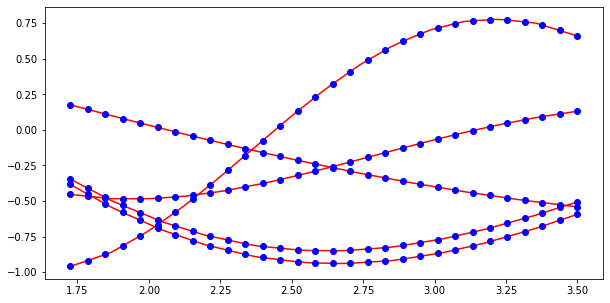

In [15]:
plt.figure(figsize=(10,5))

for i in range(0,num_samples,200):
    plt.plot(learn.clean_times,learn.clean_predictions[i,:], 'r-')
    plt.plot(times[time_start_idx:time_end_idx + 1], Q_samples_TS[i,time_start_idx:time_end_idx + 1],'bo')
    #plt.plot(times, piecewise_linear(times, q_predict_pl[i,N:2*N], q_predict_pl[i,0:N]))

In [16]:
# print(q_predict_pl[0,:])
# print(q_predict_pl[0,N:])

In [17]:
# i = 3
# plt.plot(times,Q_samples_TS[i,0:num_time_obs],'bo')
# plt.plot(times, piecewise_linear(times, q_predict_pl[i,N:], q_predict_pl[i,0:N]))

In [18]:
# num_surrogate_time_obs = num_time_obs

# surrogate_times = np.linspace(time_start, time_end, num_surrogate_time_obs)

# surrogate_predictions = np.zeros((num_samples,num_surrogate_time_obs))
# for i in range(num_samples):
#     surrogate_predictions[i,:] = piecewise_linear(surrogate_times, 
#                                              q_predict_pl[i,N:2*N], 
#                                              q_predict_pl[i,0:N])

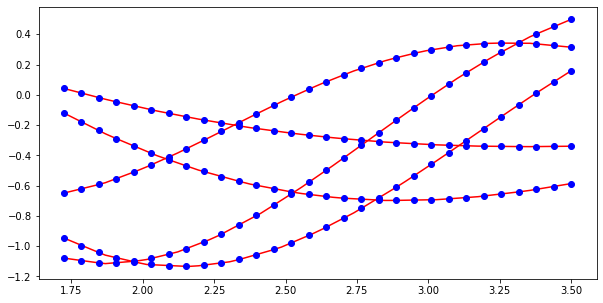

In [19]:
# i = 3
# plt.plot(times,Q_samples_TS[i,0:num_time_obs],'bo')
# plt.plot(times, piecewise_linear(times, q_predict_pl[i,N:], q_predict_pl[i,0:N]))
# plt.plot(surrogate_times, surrogate_predictions[i,:],'rs')
plt.figure(figsize=(10,5))

for i in range(0,num_samples,200):
    plt.plot(learn.clean_times,learn.clean_obs[i,:], 'r-')
    plt.plot(times[time_start_idx:time_end_idx + 1],Q_obs_samples_TS[i,time_start_idx:time_end_idx + 1],'bo')

In [20]:
kwargs = [{'n_clusters': 3,
           'n_init': 10},
          {'n_clusters': 3,
           'assign_labels': 'discretize',
           'random_state': 0}]

learn.learn_dynamics(cluster_methods=['kmeans', 'spectral'], kwargs=kwargs)

ls, rate = learn.classify_dynamics(kernel="rbf")
print(rate)

learn.learn_qoi(kernel='linear')

# from sklearn.cluster import SpectralClustering
# from sklearn.cluster import KMeans

# kmeans = False

# k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
# k_means.fit(surrogate_predictions)

# predict_labels_kmeans = k_means.labels_

# from sklearn import svm
# clustering = SpectralClustering(n_clusters=3,
#              assign_labels="discretize",
#              random_state=0).fit(surrogate_predictions)
# kernel = "rbf" # "rbf", "poly", "sigmoid", "linear"
# clf = svm.SVC(kernel=kernel, gamma='auto')
# clf.fit(surrogate_predictions, clustering.labels_)
# # clf.fit(surrogate_predictions, k_means.labels_)
# predict_labels_clustering = clf.predict(surrogate_predictions)
# #print(clf.score(surrogate_predictions, clustering.labels_))
# if kmeans:
#     predict_labels = predict_labels_kmeans
# else:
#     predict_labels = predict_labels_clustering

0.567


[KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
           fit_inverse_transform=False, gamma=None, kernel='linear',
           kernel_params=None, max_iter=None, n_components=None, n_jobs=None,
           random_state=None, remove_zero_eig=False, tol=0),
 KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
           fit_inverse_transform=False, gamma=None, kernel='linear',
           kernel_params=None, max_iter=None, n_components=None, n_jobs=None,
           random_state=None, remove_zero_eig=False, tol=0),
 KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
           fit_inverse_transform=False, gamma=None, kernel='linear',
           kernel_params=None, max_iter=None, n_components=None, n_jobs=None,
           random_state=None, remove_zero_eig=False, tol=0)]

In [21]:
# print(predict_labels_clustering)
# print(k_means.labels_)

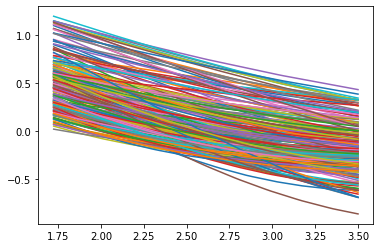

In [22]:
for i in range(num_samples):
    if learn.predict_labels[i]==2:
        plt.plot(learn.clean_times, learn.clean_predictions[i,:])

# time_idx = np.where(clustering.labels_==0)[0]
# for i in range(num_samples):   
#     plt.plot(surrogate_times[time_idx], surrogate_predictions[i,time_idx])

In [23]:
# from sklearn.decomposition import PCA, KernelPCA

# X_std_1 = scaler_1.fit_transform(surrogate_predictions[np.where(predict_labels==0)[0],:])

# X_std_2 = scaler_2.fit_transform(surrogate_predictions[np.where(predict_labels==1)[0],:])

# X_std_3 = scaler_3.fit_transform(surrogate_predictions[np.where(predict_labels==2)[0],:])                             

# kernel = "linear" #"rbf" # "linear", "poly", "sigmoid", "cosine"

# kpca1 = KernelPCA(kernel=kernel, fit_inverse_transform=False)
# kpca2 = KernelPCA(kernel=kernel, fit_inverse_transform=False)
# kpca3 = KernelPCA(kernel=kernel, fit_inverse_transform=False)

# X_kpca1 = kpca1.fit_transform(X_std_1)
# X_kpca2 = kpca2.fit_transform(X_std_2)
# X_kpca3 = kpca3.fit_transform(X_std_3)


# eig_vals_1 = kpca1.lambdas_
# eig_vals_2 = kpca2.lambdas_
# eig_vals_3 = kpca3.lambdas_


In [24]:
%reset -f out

def plot_gap(eig_vals, n):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    plt.semilogy(np.arange(np.size(eig_vals)),eig_vals, Marker='*', linestyle='')
    plt.semilogy(np.arange(np.size(eig_vals)),eig_vals[n]*np.ones(np.size(eig_vals)), 'r--')
    plt.semilogy(np.arange(np.size(eig_vals)),eig_vals[n+1]*np.ones(np.size(eig_vals)), 'r--')
    s = 'Orders of magnitude between %d and %d e.vals is %4.2f' %(n, n+1, 
                                                                  np.log10(eig_vals[n])-np.log10(eig_vals[n+1]))
    s += '\n and e.vals up to %d account for %4.2f percent of variation' %(n, 
                                                                           np.sum(eig_vals[0:n+1])/np.sum(eig_vals)*100)
    plt.title(s)

wd.interact(plot_gap,
            eig_vals = wd.fixed(eig_vals_2),
            n = wd.IntSlider(value=0, min=0, max=20))

Flushing output cache (2 entries)


NameError: name 'eig_vals_2' is not defined

In [ ]:
# %reset -f out

# def plot_eigvecs(eig_vals, eig_vecs, n):
#     fig = plt.figure(figsize=(10,10))
#     fig.clear()
#     plt.plot(np.arange(np.size(eig_vals)),eig_vecs[:,n], Marker='*', linestyle='', color='k')
#     plt.title('Eigenvector ' + str(n))
#     plt.ylim([-1,1])

# wd.interact(plot_eigvecs, 
#             eig_vals = wd.fixed(eig_vals_1),
#             eig_vecs = wd.fixed(eig_vecs_1),
#             n = wd.IntSlider(value=0,min=0,max=10))

In [ ]:
#Clear figure each time this is run to save memory
%reset -f out

#define all the potential QoI
q_predict_PCA_1 = X_kpca1 #np.dot(X_std_1, eig_vecs_1)
q_predict_PCA_2 = X_kpca2#np.dot(X_std_2, eig_vecs_2)
q_predict_PCA_3 = X_kpca3 #np.dot(X_std_3, eig_vecs_3)

#create a plot function to check out any pairs of QoI desired
def plot_QoI_pairs(q_predict, q1, q2):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    plt.scatter(q_predict[:,q1],q_predict[:,q2])
    plt.title('Visualizing the skewness/correlation between QoI ' + str(q1) + ' and ' + str(q2))

#allow interactivity of plotting
wd.interact(plot_QoI_pairs, 
            q_predict = wd.fixed(q_predict_PCA_1), 
            q1 = wd.IntSlider(value=0,min=0,max=q_predict_PCA_1[0,:].size-1,step=1), 
            q2 = wd.IntSlider(value=1,min=0,max=q_predict_PCA_1[0,:].size-1,step=1),
            continuous_update=False)

### Now choose how many QoI to use from the principal components and construct a predicted density either using a standard Gaussian KDE 

***Still to-do:*** Try just using machine learning to determine an optimal KDE with a chosen kernel that allows for compact support and uses cross-validation to optimize bandwidth. Need to investigate further. Code below is commented out because it takes too long to run.

In [ ]:
QoI_list = range(4)
QoI_num = len(QoI_list)

q_predict_maps = [q_predict_PCA_1[:,QoI_list], q_predict_PCA_2[:,QoI_list], q_predict_PCA_3[:,QoI_list]]

pi_Q_kdes = [GKDE( q_predict_maps[0].T ), GKDE( q_predict_maps[1].T ), GKDE( q_predict_maps[2].T )]

### Now transform the observations.

In [ ]:
q_obs_pl = np.zeros((num_obs_samples,2*N-2))

p0_init = np.hstack([np.zeros(N), knots_init])
p0_init[0] = 1

for i in range(num_obs_samples):
    q_obs_pl[i,:], _ = optimize.curve_fit(lambda x, *params_0: wrapper_fit_func(x, N, params_0), 
                                          times, Q_obs_samples_TS[i,:], 
                                          p0=p0_init)

In [ ]:
surrogate_obs = np.zeros((num_obs_samples,num_surrogate_time_obs))
for i in range(num_samples):
    surrogate_obs[i,:] = piecewise_linear(surrogate_times, 
                                          q_obs_pl[i,N:2*N], 
                                          q_obs_pl[i,0:N])

In [ ]:
# obs_labels = k_means.predict(surrogate_obs)
if kmeans:
    obs_labels = k_means.predict(surrogate_obs)
else:
    obs_labels = clf.predict(surrogate_obs) #clustering.transform(surrogate_obs)
print(obs_labels)

In [ ]:
plt.figure()

cluster_num = 0
for i in range(num_samples):
    if predict_labels[i]==cluster_num:
        plt.plot(surrogate_times, surrogate_predictions[i,:],'b*')

for i in range(num_obs_samples): 
    if obs_labels[i]==cluster_num:
        plt.plot(surrogate_times, surrogate_obs[i,:],'r')

In [ ]:
X_test_1 = scaler_1.transform(surrogate_obs[np.where(obs_labels==0)[0],:])

X_test_2 = scaler_2.transform(surrogate_obs[np.where(obs_labels==1)[0],:])

X_test_3 = scaler_3.transform(surrogate_obs[np.where(obs_labels==2)[0],:])                             

q_obs_PCA_1 = kpca1.transform(X_test_1)#np.dot(X_test_1, eig_vecs_1)

q_obs_PCA_2 = kpca2.transform(X_test_2)#np.dot(X_test_2, eig_vecs_2)

q_obs_PCA_3 = kpca3.transform(X_test_3)#np.dot(X_test_3, eig_vecs_3)

In [ ]:
# Visually inspect results
#Clear figure each time this is run to save memory
%reset -f out

#create a plot function to check out any pairs of QoI desired
def plot_QoI_pairs(q_predict, q_obs, q1, q2):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    plt.scatter(q_predict[:,q1],q_predict[:,q2])
    plt.scatter(q_obs[:,q1],q_obs[:,q2])

#allow interactivity of plotting
wd.interact(plot_QoI_pairs, 
            q_predict = wd.fixed(q_predict_PCA_2), 
            q_obs = wd.fixed(q_obs_PCA_2),
            q1 = wd.IntSlider(value=0,min=0,max=q_predict_PCA_2[0,:].size-1,step=1), 
            q2 = wd.IntSlider(value=1,min=0,max=q_predict_PCA_2[0,:].size-1,step=1),
            continuous_update=False)

#### Now extract the same number of QoI from the observed set and construct an observed density.

In [ ]:
q_obs_maps = [q_obs_PCA_1[:,QoI_list], q_obs_PCA_2[:,QoI_list], q_obs_PCA_3[:,QoI_list]]

pi_obs_kdes = [GKDE( q_obs_maps[0].T ), GKDE( q_obs_maps[1].T ), GKDE( q_obs_maps[2].T )]

### Now perform rejection sampling on predicted set to obtain an i.i.d. sample set from a distribution consistent with the observed (consistent in the sense that it comes from a pullback measure).

We printout the acceptance rate of samples as well as the mean value of the rejection ratio 

$$
    r(\lambda) = \frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_\mathcal{D}^{predict}(Q(\lambda))}, 
$$

which should be ***close*** to 1 to indicate that the updated density defined by

$$
    \pi_\Lambda^{update} = \pi_\Lambda^{predict}(\lambda)\frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_\mathcal{D}^{predict}(Q(\lambda))}
$$

is in fact a density. This form and result follows from the disintegration theorem. See [Combining Push-Forward Measures and Bayes' Rule to Construct Consistent Solutions to Stochastic Inverse Problems](https://epubs.siam.org/doi/abs/10.1137/16M1087229) for more details (note that I am using notation more consistent with the newer reference on this subject found [here](https://epubs.siam.org/doi/abs/10.1137/18M1181675) on convergence properties of this updated density using approximate QoI maps).

In [ ]:
num_clusters = 3

r = []
samples_to_keep = []
consistent_lam = []

for i in range(num_clusters):
#First compute the rejection ratio
    r.append(np.divide(pi_obs_kdes[i](q_predict_maps[i].T),pi_Q_kdes[i](q_predict_maps[i].T)))

    #Now perform rejection sampling and return the indices we keep
    samples_to_keep.append(rejection_sampling(r[i]))

    #Now print some diagnostics
    print(r[i].mean()) # Want this close to 1

In [ ]:
# # Visually inspect results
# #Clear figure each time this is run to save memory
# %reset -f out

# #create a plot function to check out any pairs of lambda desired
# def plot_lambda_pairs(lam1, lam2):
#     fig = plt.figure(figsize=(10,10))
#     fig.clear()
#     plt.scatter(lam[:,lam1],lam[:,lam2])
#     plt.scatter(lam_obs[:,lam1],lam_obs[:,lam2])
#     plt.scatter(consistent_lam[:,lam1],consistent_lam[:,lam2])

# #allow interactivity of plotting
# wd.interact(plot_lambda_pairs, 
#             lam1 = wd.IntSlider(value=0,min=0,max=3,step=1), 
#             lam2 = wd.IntSlider(value=1,min=0,max=3,step=1),
#             continuous_update=False)

### Estimate marginals of parameters using a weighted KDE fit. This requires `scipy` to be version 1.2.1.

In [ ]:
param_marginals = []
true_sample_marginals = []

lam_ptr = [np.where(predict_labels==0)[0],
           np.where(predict_labels==1)[0],
           np.where(predict_labels==2)[0]]

cluster_weights = [len(np.where(obs_labels==0)[0]) / num_obs_samples,
                   len(np.where(obs_labels==1)[0]) / num_obs_samples,
                   len(np.where(obs_labels==2)[0]) / num_obs_samples] 

for i in range(4):
    true_sample_marginals.append(GKDE(lam_obs[:,i]))
    param_marginals.append([])
    for j in range(num_clusters):
        param_marginals[i].append(GKDE(lam[lam_ptr[j],i], weights=r[j]))

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()
x = np.linspace(0.1,1,100)
plt.plot(x, 1/.9*np.ones(100), label = 'Initial guess')
plt.plot(x, param_marginals[0][0](x) * cluster_weights[0] 
           +param_marginals[0][1](x) * cluster_weights[1]
           +param_marginals[0][2](x) * cluster_weights[2], label = 'Estimated pullback')
plt.plot(x, true_sample_marginals[0](x), label = 'Actual density')
plt.title('Comparing pullback to actual density of parameter $c$', fontsize=16)
plt.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()
x = np.linspace(0.5,2,100)
plt.plot(x, 1/1.5*np.ones(100), label = 'Initial guess')
plt.plot(x, param_marginals[1][0](x) * cluster_weights[0] 
           +param_marginals[1][1](x) * cluster_weights[1]
           +param_marginals[1][2](x) * cluster_weights[2], label = 'Estimated pullback')
plt.plot(x, true_sample_marginals[1](x), label = 'Actual density')
plt.title('Comparing pullback to actual density of parameter $\omega_0$', fontsize=16)
plt.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()
x = np.linspace(1,2,100)
plt.plot(x, 1*np.ones(100), label = 'Initial guess')
plt.plot(x, param_marginals[2][0](x) * cluster_weights[0] 
           +param_marginals[2][1](x) * cluster_weights[1]
           +param_marginals[2][2](x) * cluster_weights[2], label = 'Estimated pullback')
plt.plot(x, true_sample_marginals[2](x), label = 'Actual density')
plt.title('Comparing pullback to actual density of parameter $a$', fontsize=16)
plt.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()
x = np.linspace(-1,0,100)
plt.plot(x, 1*np.ones(100), label = 'Initial guess')
plt.plot(x, param_marginals[3][0](x) * cluster_weights[0] 
           +param_marginals[3][1](x) * cluster_weights[1]
           +param_marginals[3][2](x) * cluster_weights[2], label = 'Estimated pullback')
plt.plot(x, true_sample_marginals[3](x), label = 'Actual density')
plt.title('Comparing pullback to actual density of parameter $b$', fontsize=16)
plt.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()

plt.scatter(lam[lam_ptr[0],3],q_predict_PCA_1[:,2])

## Workflow of BET + LoQ

BET.solve_TS_data(predicted_time_series_array, observed_time_series_array)

### User does not see the following calls

LoQ.clean_data()

LoQ.learn_dynamics <--- labeling

LoQ.classify_dynamics <--- svm

LoQ.learn_QoI <---- kPCA

LoQ.classify_observations <---- svm to label observations
LoQ.transform_observations <--- kPCA on labeled oversations

LoQ.create_sample_objects <---- output sample objects for predicted and observed QoI

## For non-time series (i.e., for spatial) data

BET.solve_spatial_data(spatial_data_array, observed_time_series_array)

No call to LoQ.clean_data()